In [3]:
from pysubspaces.RNN import tasks
from pysubspaces.RNN.utils import train

ModuleNotFoundError: No module named 'pysubspaces'

In [3]:
from platform import python_version

In [5]:
python_version()

'3.9.7'

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

ModuleNotFoundError: No module named 'torch'

In [5]:
import matplotlib.pyplot as plt
import ipywidgets
from tqdm.auto import tqdm
import seaborn as sns

from sklearn.decomposition import PCA, FactorAnalysis
import pandas as pd

In [4]:
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from pysubspaces import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LinearRegression

In [6]:
torch.set_num_threads(1)

# Define model 

In [7]:
import torch
import torch.nn as nn
import numpy as np

from pysubspaces.RNN import utils

class VanillaRNN(nn.Module):
    def __init__(self,
                 n_inputs: int, n_outputs: int, n_neurons: int,
                 alpha: float, 
                 nonlin: callable,
                 weight_init: str,
                 init_scales: dict = None,
                 p_rec: float = 1.,
                 p_in: float = 1.,
                 dynamics_noise: float = None,
                 bias: bool = True,
                 train_input_weights: bool = False,
                 train_output_weights: bool = False,
                 W_out_norm: float = None,
                 rec_rank: int = None,
                 use_constant_init_state: bool = False):
        super().__init__()

        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.alpha = alpha
        self.nonlin = nonlin
        self.p_in = p_in
        self.p_rec = p_rec
        self.nonlin_fn = nonlin
        self.bias = bias
        self.use_constant_init_state = use_constant_init_state

        
        if dynamics_noise is None:
            self.noisy = False
            self.noise_amp = 0
        else:
            self.noisy = True
            self.noise_amp = dynamics_noise

            
        if weight_init == 'glorot_gauss':
            self.glorot_gauss_init()
        elif weight_init == 'jobarb':
            if init_scales is None:
                init_scales = {}
            for g in ['g', 'g_in', 'g_out']:
                setattr(self, g, init_scales.get(g, 1.1))
            self.jobarb_init()
        else:
            raise ValueError("weight_init has to be either 'jobarb' or 'glorot_gauss'")
            
            
        if W_out_norm is not None:
            self.W_out = nn.Parameter(self.W_out / self.W_out.norm() * W_out_norm)
            
        if not train_input_weights:
            self.W_in.requires_grad = False
        if not train_output_weights:
            self.W_out.requires_grad = False
            
        if rec_rank is not None:
            import geotorch
            geotorch.low_rank(self, 'W_rec', rec_rank)
            self.rec_rank = rec_rank
        else:
            self.rec_rank = 'full'

        # for potentially initializing to the same state in every trial
        init_x = self.init_hidden()
        self.register_buffer('init_x', init_x)
        

    
    def init_hidden(self):
        # from Joanna's code
        # needs to be small !! as rates are regularized during training -> so going small
        #return (torch.tensor(np.random.uniform(-0.1, 0.1, size = (1, self.batch_size, self.n_neurons))).type(self.dtype),
        #        torch.tensor(np.random.uniform(-0.1, 0.1, size = (1, self.batch_size, self.n_neurons_l2))).type(self.dtype))

        # from PsychRNN
        return .1 + .01 * torch.randn(self.n_neurons)
    

    def forward(self, X, r_overwrite=None):
        self.batch_size = X.size(1)

        # intial activity
        if self.use_constant_init_state:
            init_state = torch.tile(self.init_x, (1, self.batch_size, 1))
        else:
            init_state = torch.tile(self.init_hidden(), (1, self.batch_size, 1))
        
        x = init_state.to(self.device)
        r = self.nonlin_fn(x).to(self.device)

        outv   = []
        hidden = []
        for j in range(X.size(0)):
            x, r = self.f_step(X[j], x, r) # maybe an input here for modular

            if r_overwrite is not None:
                r = r_overwrite[j]
            
            hidden.append(r.to(self.device))
            outv.append(r @ self.W_out.T)

        
        return torch.stack(outv).squeeze(), (torch.stack(hidden).squeeze(), )

    
    def f_step(self, xin, x, r):
        x = x + self.alpha * (-x + r @ (self.rec_mask * self.W_rec).T
                                 + xin @ (self.input_mask * self.W_in).T
                                 + self.bias)
        
        # TODO have multiple inputs (for connections with other modules)
        # something like
        #for (r_in, mask_in) in zip(input_rates, input_masks):
        #    x += self.alpha * (r_in @ mask_in).T

        if self.noisy:
            x += self.alpha * self.noise_amp * torch.randn(1, self.batch_size, self.n_neurons).to(self.device)
            
        r = self.nonlin_fn(x)

        return x, r


    def glorot_gauss_init(self):
        input_mask = torch.rand(self.n_neurons, self.n_inputs) < self.p_in
        self.W_in = nn.Parameter(utils.glorot_gauss_tensor(connectivity=input_mask))
        self.register_buffer('input_mask', input_mask)

        W_out = utils.glorot_gauss_tensor((self.n_outputs, self.n_neurons))
        self.W_out = nn.Parameter(W_out)

        rec_mask = torch.rand(self.n_neurons, self.n_neurons) < self.p_rec
        self.W_rec = nn.Parameter(utils.glorot_gauss_tensor(connectivity=rec_mask))
        self.register_buffer('rec_mask', rec_mask)

        if self.bias:
            self.bias = nn.Parameter(utils.glorot_gauss_tensor((1, self.n_neurons)))
        else:
            self.bias = nn.Parameter(torch.zeros((1, self.n_neurons)))
            self.bias.requires_grad = False


    def jobarb_init(self):
        self.W_rec = nn.Parameter((self.g / np.sqrt(self.n_neurons) * torch.randn(self.n_neurons, self.n_neurons)).type(self.dtype))
        
        # why uniform?
        self.W_in  = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, size = (self.n_neurons, self.n_inputs)) * self.g_in).type(self.dtype))
        self.W_out = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, size = (self.n_outputs, self.n_neurons)) * self.g_out).type(self.dtype))
        
        # restrict connectivity
        self.ff_mask = torch.rand(self.n_neurons, self.n_neurons).type(self.dtype) < self.p_intermodule
        self.rec_mask = torch.rand(self.n_neurons, self.n_neurons).type(self.dtype) < self.p_rec


    @property
    def device(self):
        return next(self.parameters()).device

    @property
    def dtype(self):
        return next(self.parameters()).dtype
    
    @property
    def norm_in(self):
        return (self.input_mask * self.W_in).norm()

    @property
    def norm_out(self):
        return self.W_out.norm()

    @property
    def norm_rec(self):
        return (self.rec_mask * self.W_rec).norm()
    
    @property
    def num_modules(self):
        return 1

In [8]:
# TODO: modify this so that the keys in `weights` are not greek letter but the name of the tensor
# then it can be universal for both 1 and 2 module networks

    
mse = nn.MSELoss()
class MSEOnlyLoss(nn.Module):
    def forward(self, rnn, target_output, mask, model_output, rates):
        #error = mse(target_output, model_output)
        error = mse(target_output * mask, model_output * mask)
        return error, error
        
        
class TolerantLoss(nn.Module):
    def __init__(self, tolerance_in_deg):
        super(TolerantLoss, self).__init__()
        self.tolerance_in_deg = tolerance_in_deg
        self.tolerance_in_rad = np.deg2rad(self.tolerance_in_deg)
        
    def forward(self, rnn, target_output, mask, model_output, rates):
        model_angle  = torch.atan2(model_output[:, :, 1], model_output[:, :, 0])
        target_angle = torch.atan2(target_output[:, :, 1], target_output[:, :, 0])

        angle_incorrect = torch.abs(model_angle - target_angle) > self.tolerance_in_rad

        error = mse(angle_incorrect.T * mask.T * target_output.T, angle_incorrect.T * mask.T * model_output.T)
        
        return error, error

In [9]:
n = 50

# default 0.2
clipgrad = 1. # what is this for exactly and how do you set it?
# took 1. from PsychRNN

tau = 25
dt = 5
alpha = dt / tau

connection_params = {
    'p_in' : 1.,
    'p_rec' : 1.,
}

tolerance = 5.

noise = 0.05 # noise in the dynamics
#noise = None # noise in the dynamics

#nonlin_fn = torch.tanh
nonlin_fn = F.relu

# Create and train

In [10]:
L = 1200
batch_size = 64
#batch_size = 32

training_iters = 1_000
lr = 1e-3

#weighted_loss = MSEOnlyLoss()
#test_loss_fn = MSEOnlyLoss()
# tolerant loss is slower to compute but closer to the actual task
weighted_loss = TolerantLoss(tolerance)
test_loss_fn = TolerantLoss(tolerance)

In [11]:
output_norm_vals = [0.2, 1., 2., 10.]
rec_rank_vals = [1, 2, 3, 4, 5, None]

In [12]:
def _instantiate_rnn(task, params):
    return VanillaRNN(task.N_in, task.N_out, n, alpha, nonlin_fn, 'glorot_gauss', dynamics_noise=noise, **connection_params,
                      bias = False,
                      W_out_norm = params['output_norm'],
                      rec_rank = params['rec_rank'])

def train_with_params(params):
    torch.set_num_threads(1)
    
    output_norm = params['output_norm']
    rec_rank = params['rec_rank']
    
    task = tasks.CossinUncertaintyTaskWithReachProfiles(dt, tau, L, batch_size, target_kappa = 25)

    rnn = _instantiate_rnn(task, params)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, rnn.parameters()),
                           lr = lr)
    
    training_losses, regularized_losses = train(rnn, task, training_iters, optimizer, weighted_loss, test_loss_fn)

    return params, task, rnn.state_dict(), optimizer.state_dict(), training_losses

In [13]:
# sequential training: worked

#results = []
#for output_norm in output_norm_vals:
#    for rec_rank in rec_rank_vals:
#        results.append(train_with_params({'output_norm' : output_norm, 'rec_rank' : rec_rank}))

In [14]:
params_parallel = []
for output_norm in output_norm_vals:
    for rec_rank in rec_rank_vals:
        params_parallel.append({'output_norm' : output_norm,
                                'rec_rank' : rec_rank})

In [15]:
len(params_parallel)

24

In [16]:
from joblib import Parallel, delayed

n_jobs = min(len(params_parallel), 20)

results = Parallel(n_jobs = n_jobs, backend = 'loky')(delayed(train_with_params)(p) for p in tqdm(params_parallel))

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:04<00:00,  1.38it/s]


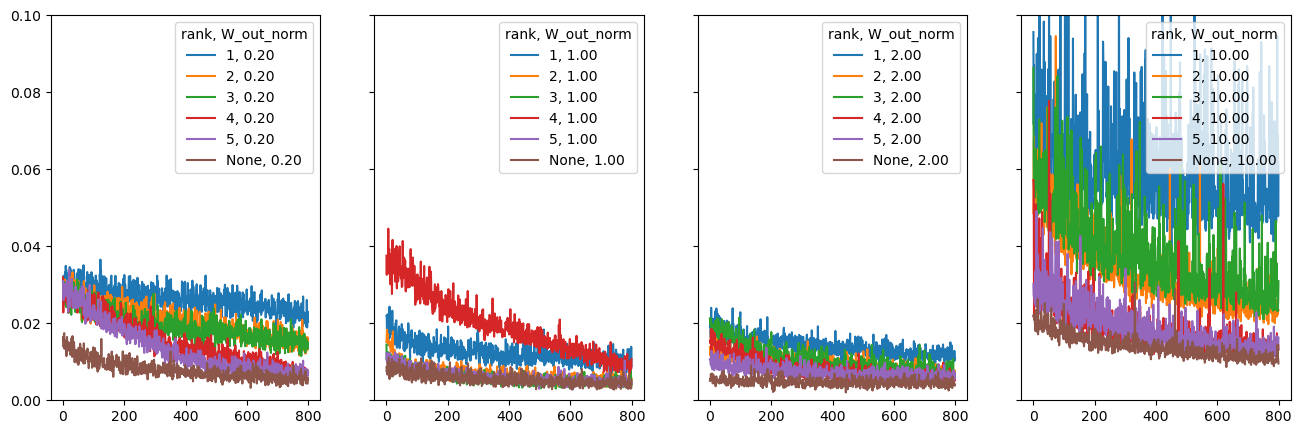

In [17]:
fig, ax = plt.subplots(figsize = (16, 5), ncols = len(output_norm_vals), sharey = True)

start_iter = 200
ylim = 0.1

for res in results:
    params, task, rnn_state_dict, optimizer_state_dict, losses = res
    
    rnn = _instantiate_rnn(task, params)
    rnn.load_state_dict(rnn_state_dict)
    rnn.rec_rank = params['rec_rank']
    
    #optimizer.load_state_dict(optimizer_state_dict)
    
    assert np.isclose(rnn.W_out.norm(), params['output_norm'])
    
    for (i, output_norm) in enumerate(output_norm_vals):
        if np.isclose(rnn.W_out.norm(), output_norm):
            ax[i].plot(losses[start_iter:], label = f"{rnn.rec_rank}, {output_norm:.2f}")
    
for axi in ax:
    axi.legend(title = "rank, W_out_norm")
    axi.set_ylim(0, ylim)

In [18]:
training_loss_per_model = [np.mean(res[-1][-50:]) for res in results]

# Run test trials 

In [19]:
from pysubspaces.RNN.utils import run_test_batches

In [20]:
test_task = tasks.CossinUncertaintyTaskWithReachProfiles(dt, tau, L, batch_size, target_kappa = 25)

In [21]:
test_dataframes = []
for res in tqdm(results):
    params, task, rnn_state_dict, optimizer_state_dict, losses = res
    
    rnn = _instantiate_rnn(task, params)
    rnn.load_state_dict(rnn_state_dict)
    rnn.rec_rank = params['rec_rank']
    
    #optimizer.load_state_dict(optimizer_state_dict)
    assert np.isclose(rnn.W_out.norm(), params['output_norm'])
    
    df = run_test_batches(10, rnn, test_task, end_offset=0)
    #df = df.query(f"0 < endpoint_location < {np.pi}")
    
    df['out_norm'] = params['output_norm']
    df['rec_rank'] = params['rec_rank']
    
    test_dataframes.append(df)

  0%|          | 0/24 [00:00<?, ?it/s]

In [22]:
def success_rate(df: pd.DataFrame, tolerance_in_deg: float) -> float:
    return np.mean(np.abs(np.rad2deg(df.target_dir - df.endpoint_location)) < tolerance_in_deg)

In [23]:
def get_output_norm(df: pd.DataFrame) -> float:
    return np.round(df.out_norm.values[0], decimals = 2)

def get_rec_rank(df: pd.DataFrame) -> float:
    return df.rec_rank.values[0]

In [24]:
score_tuples = [(get_output_norm(df), get_rec_rank(df), success_rate(df, tolerance), tloss)
                for (df, tloss) in zip(test_dataframes, training_loss_per_model)]

score_df = pd.DataFrame(score_tuples, columns = ('out_norm', 'rec_rank', 'success_rate', 'training_loss'))

In [25]:
score_df.out_norm = np.round(score_df.out_norm, decimals = 2)

Success rate

<AxesSubplot:xlabel='rec_rank', ylabel='out_norm'>

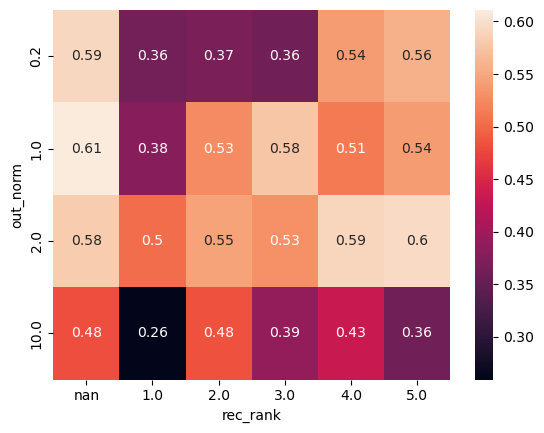

In [26]:
sns.heatmap(score_df.pivot(index = 'out_norm', columns = 'rec_rank', values = 'success_rate'), annot = True)

Training loss

<AxesSubplot:xlabel='rec_rank', ylabel='out_norm'>

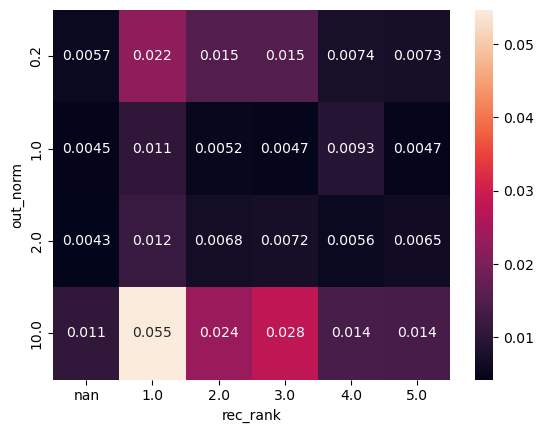

In [27]:
sns.heatmap(score_df.pivot(index = 'out_norm', columns = 'rec_rank', values = 'training_loss'), annot = True)

Activity dimensionality

In [28]:
from pyaldata import *
import pysubspaces.RNN.utils as utils # get overwritten by pyaldata

<AxesSubplot:xlabel='rec_rank', ylabel='output_norm'>

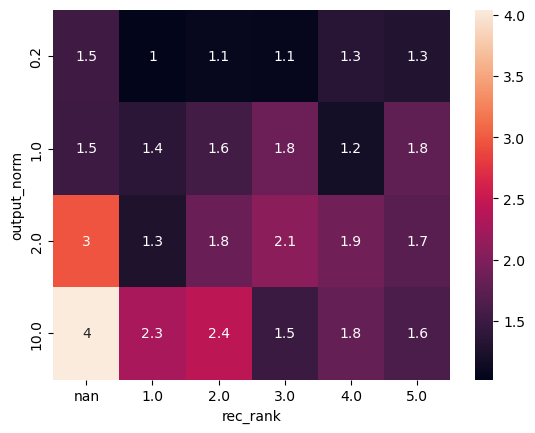

In [29]:
dim_tuples = []
for df in test_dataframes:
    dim_tuples.append((get_output_norm(df), get_rec_rank(df), pca_pr(concat_trials(df, 'PMd_rates'))))
    
dim_df = pd.DataFrame(dim_tuples, columns = ('output_norm', 'rec_rank', 'dimensionality'))

sns.heatmap(dim_df.pivot(index = 'output_norm', columns = 'rec_rank', values = 'dimensionality'), annot = True)

# Look at behavior 

In [30]:
from pysubspaces.RNN.plotting import plot_output_per_trial, make_bias_plot_per_cue_kappa
from pysubspaces.plotting import plot_identity

/home/bb2020/research_code/pysubspaces/pysubspaces/RNN/plotting.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (6*n_ck, 4), ncols = max(n_ck, 2))


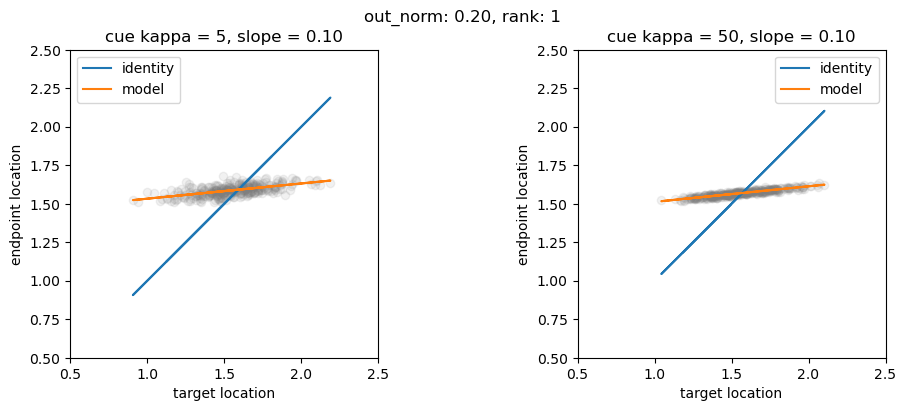

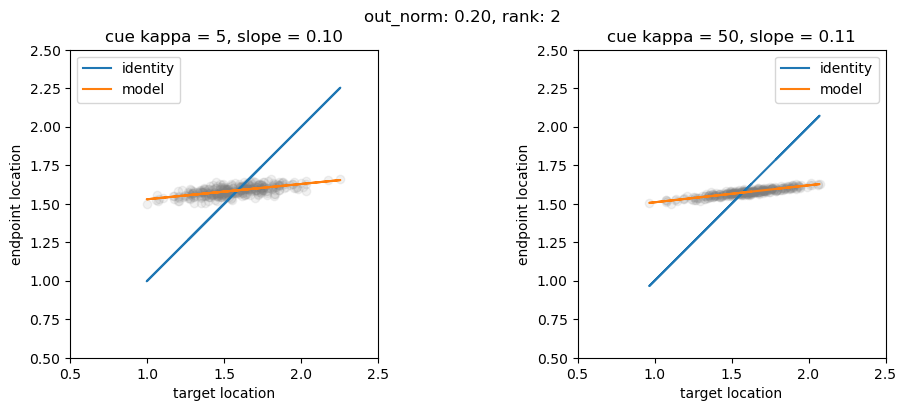

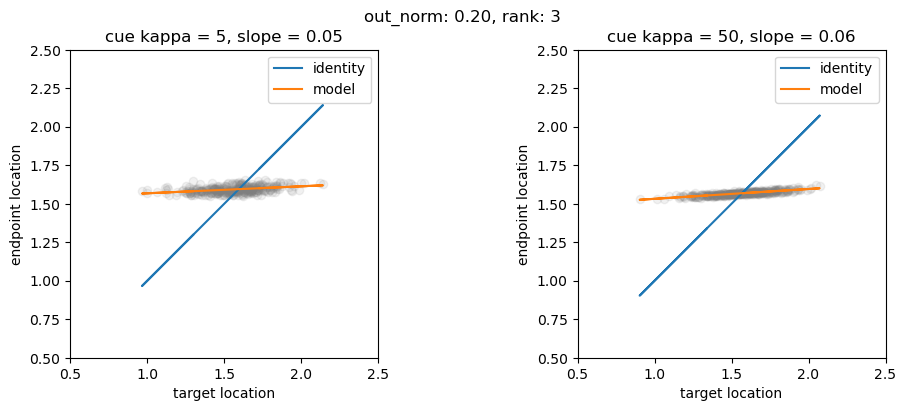

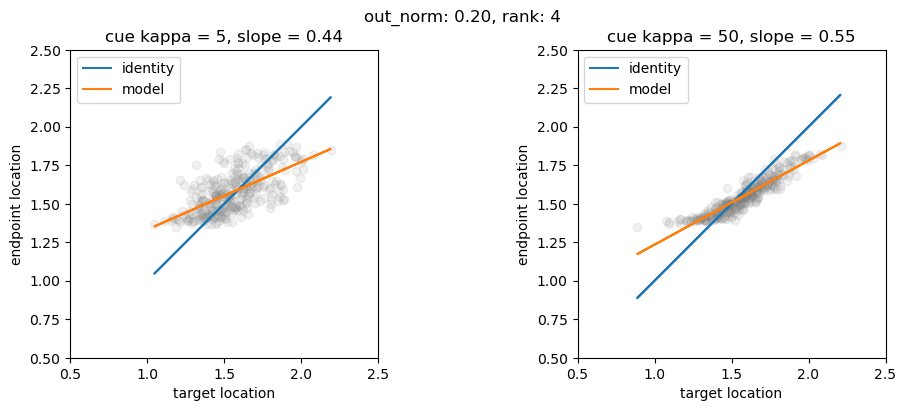

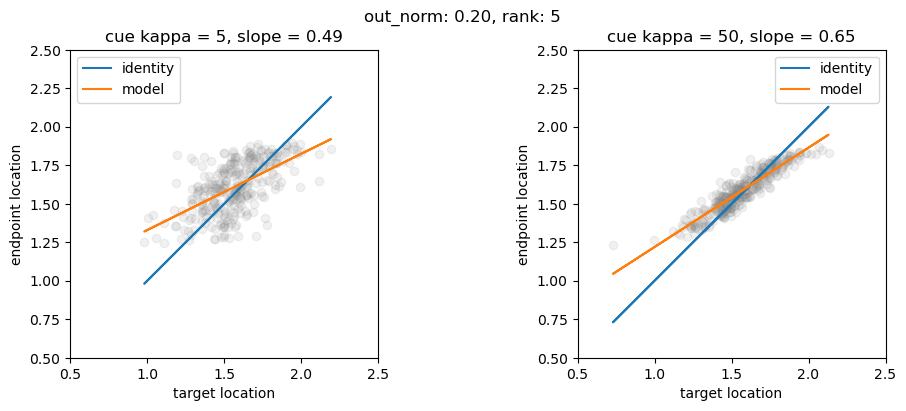

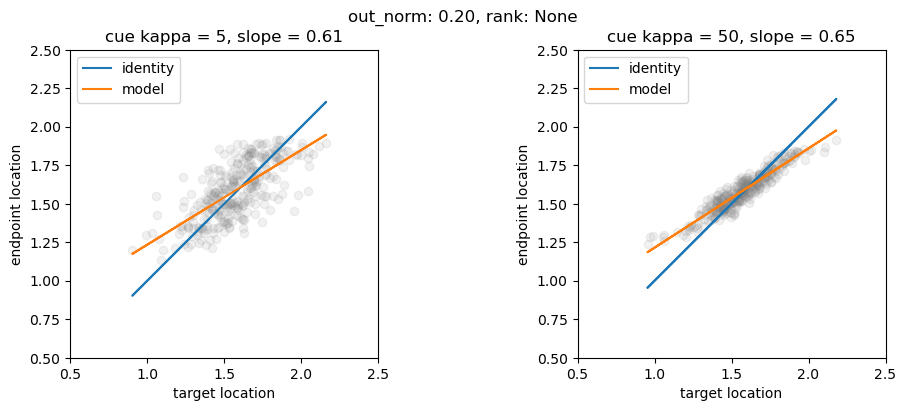

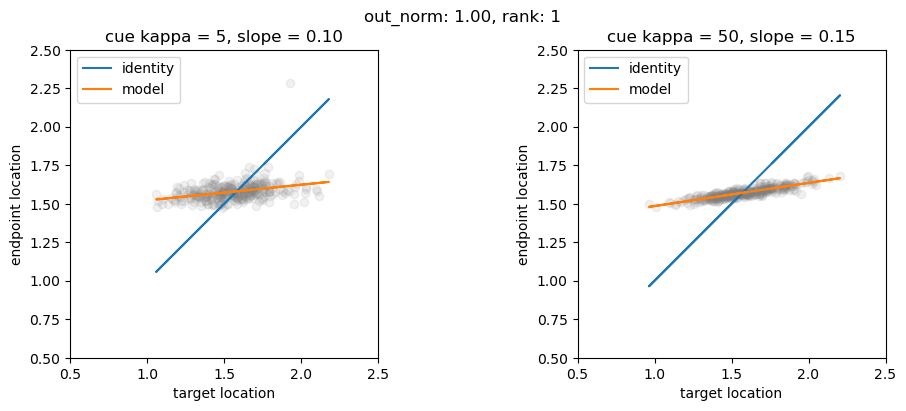

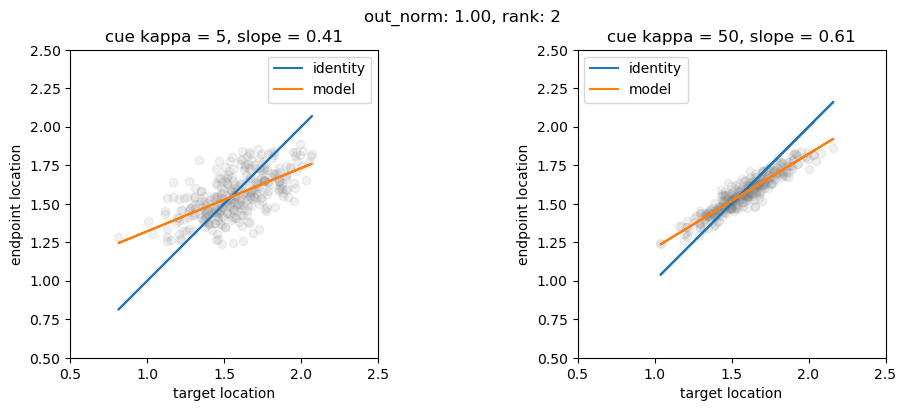

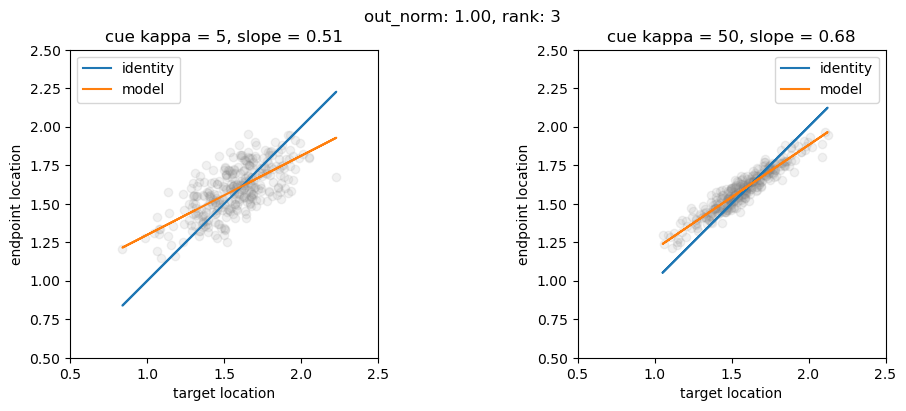

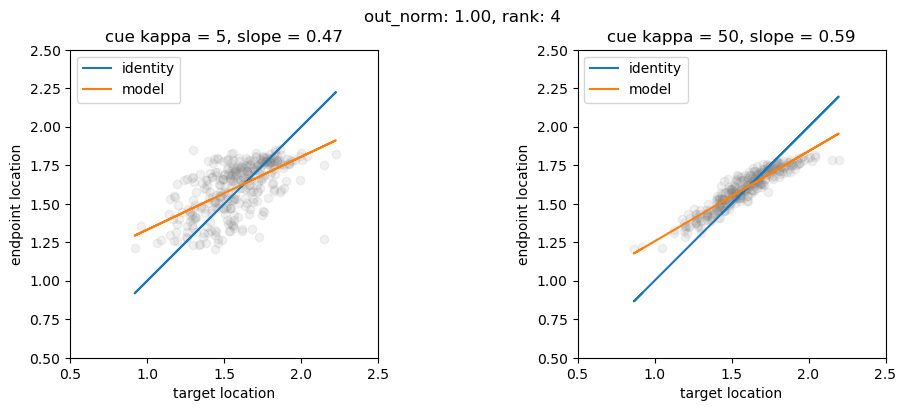

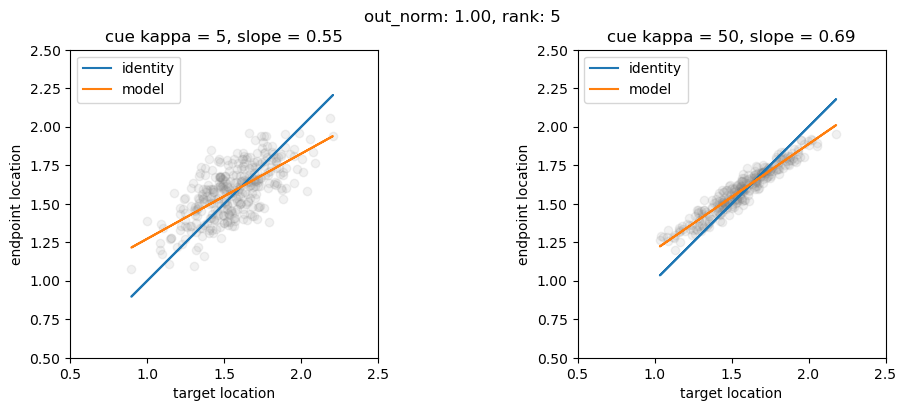

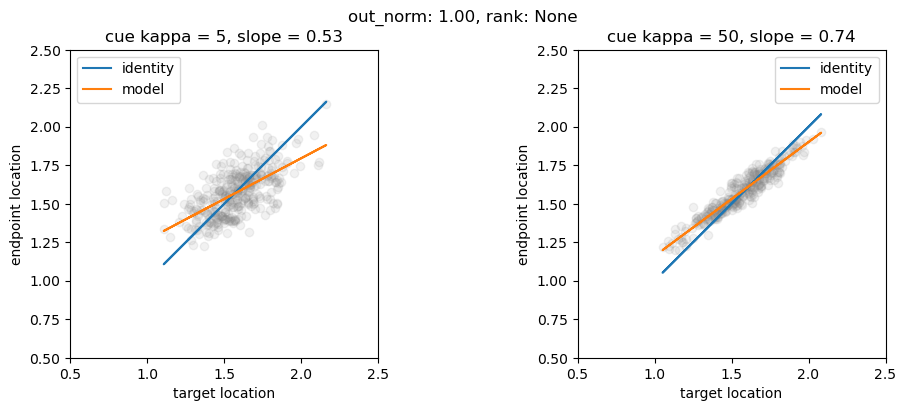

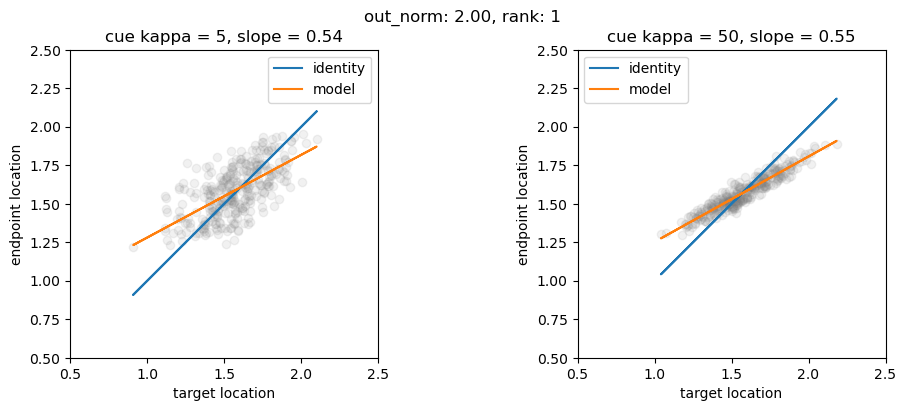

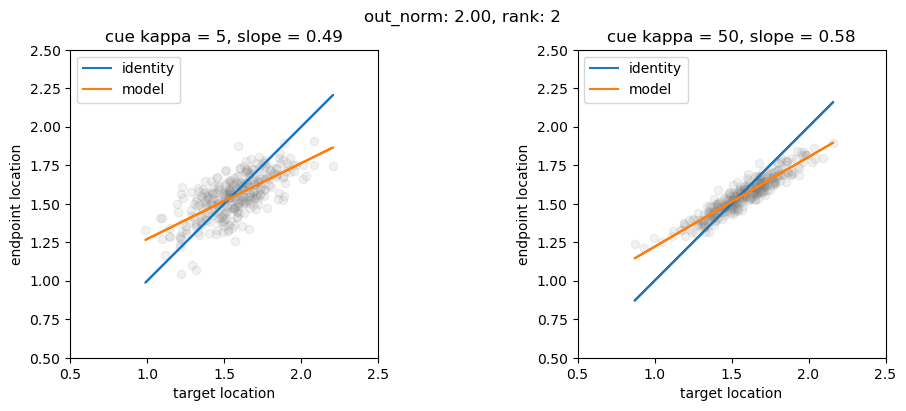

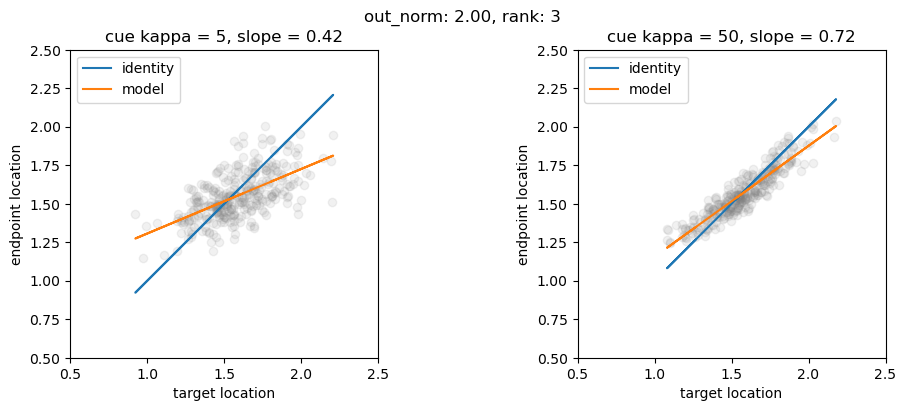

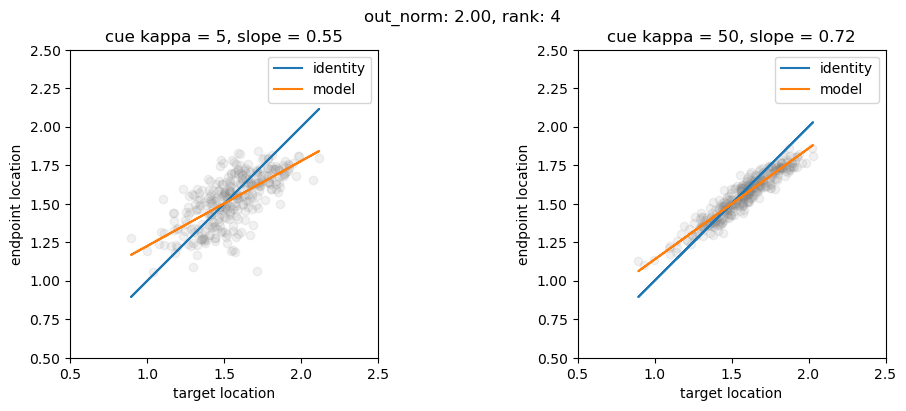

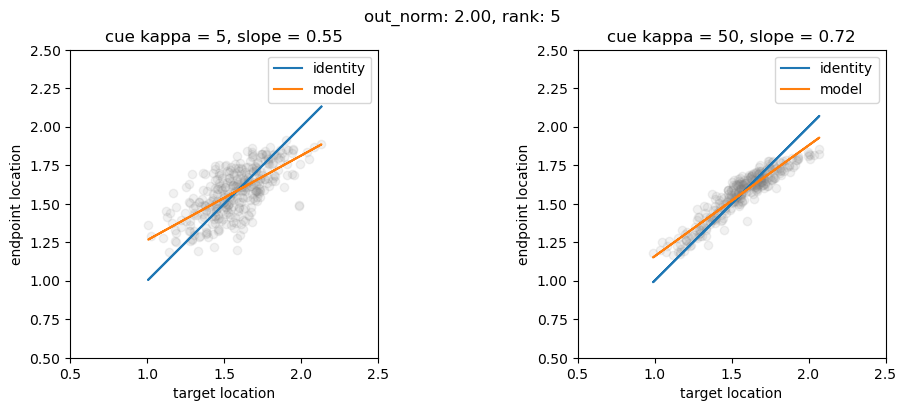

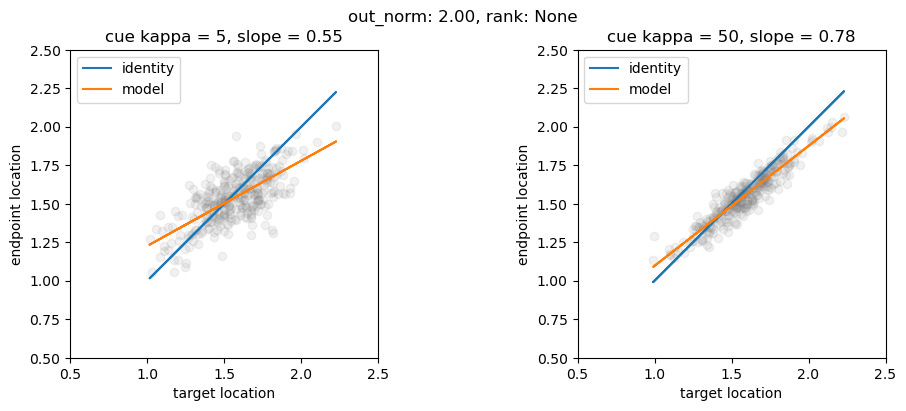

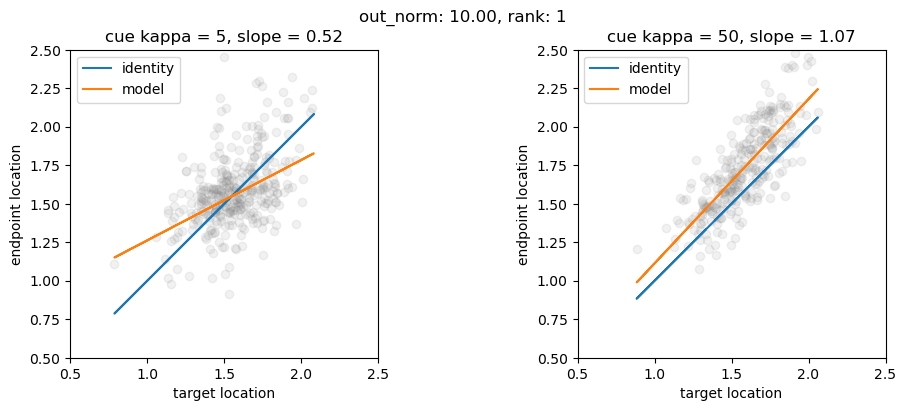

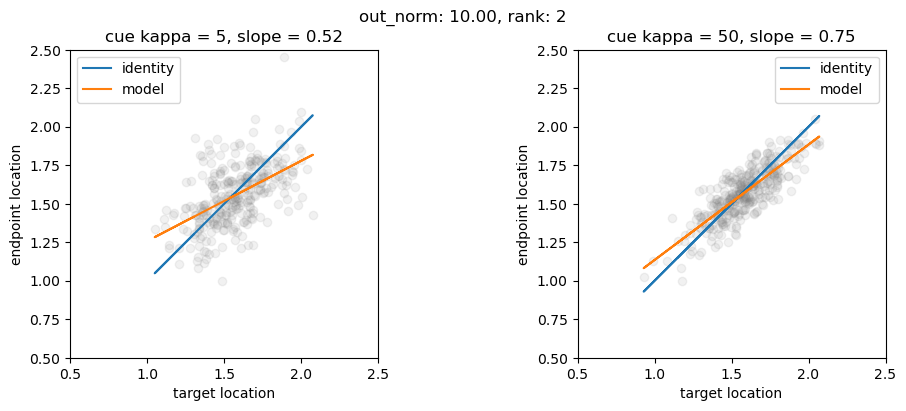

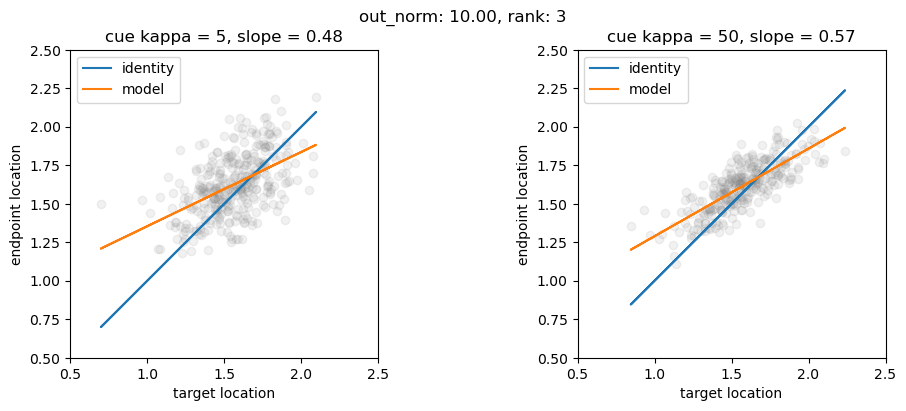

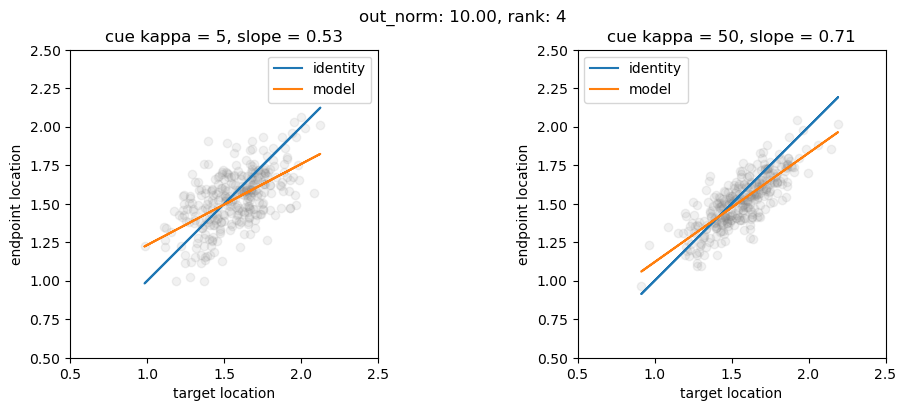

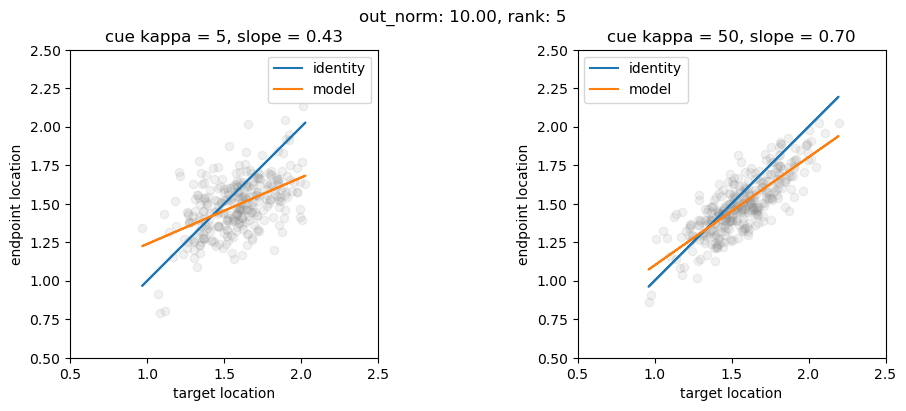

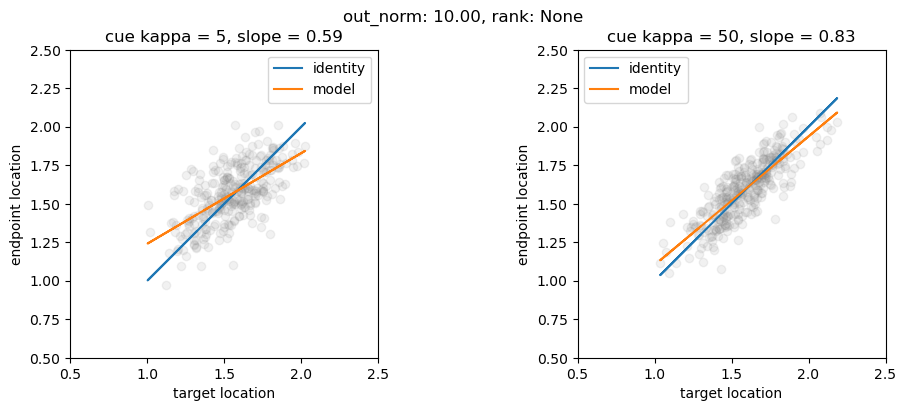

In [31]:
%matplotlib inline
for df in test_dataframes:
    try:
        fig, ax = make_bias_plot_per_cue_kappa(df);
    except:
        print(df.out_norm.values[0], df.rec_rank.values[0])
    fig.suptitle(f"out_norm: {df.out_norm.values[0]:.2f}, rank: {df.rec_rank.values[0]}")
    fig.show()

In [32]:
#%matplotlib widget
#plot_output_per_trial(df)

# Preparatory rates 

In [33]:
from pyaldata import *
import pysubspaces.RNN.utils as utils

In [34]:
#def expand_field_in_time(trial_data, field):
#    """
#    Expand scalar field to a vector that can be used for prediction per time point.
#
#    Parameters
#    ----------
#    trial_data : pd.DataFrame
#        data in trial_data format
#    field : string
#        field to expand
#
#    Returns
#    -------
#    array of length T where T is the sum of lengths of the trials in the dataframe
#    (similarly to concat_trials(trial_data, some_time_varying_field))
#    """
#    return np.concatenate([trial[field] * np.ones(get_trial_length(trial))
#                           for (i, trial) in trial_data.iterrows()])

In [35]:
def interactive_trajectory_plot(dataframes, n_samples = 100):
    fig = go.Figure(layout = {'width' : 800, 'height' : 500, 'scene' : {'aspectmode' : 'data'}})
    
    @ipywidgets.interact
    def _(area = ['PMd_proj', 'M1_proj', 'both_proj', 'model_output'],
          out_norm = output_norm_vals,
          rec_rank = rec_rank_vals,
          color_by = ['cue_mean', 'endpoint_location', 'cue_spread', 'cue_var', 'cue_kappa', 'cue_var_log', 'bias', 'rot', 'time']):
        
        candidate_dfs = [df for df in dataframes if np.isclose(get_output_norm(df), out_norm) and get_rec_rank(df) == rec_rank]
        assert len(candidate_dfs) == 1
        sampled_df = candidate_dfs[0].sample(n_samples)

        fig.data = []

        arr = concat_trials(sampled_df, area)[:, :3]

        if color_by == "time":
            c_arr = np.concatenate([np.arange(x.shape[0]) for x in sampled_df[area]])
        else:
            sampled_df = expand_field_in_time(sampled_df, color_by)
            c_arr = concat_trials(sampled_df, color_by + '_ext')

        if area == "model_output":
            fig.add_scatter(x = arr[:, 0],
                              y = arr[:, 1],
                              mode = 'markers',
                              marker = dict(size = 3,
                                            color = c_arr)
                             )
        else:
            fig.add_scatter3d(x = arr[:, 0],
                              y = arr[:, 1],
                              z = arr[:, 2],
                              mode = 'markers',
                              marker = dict(size = 3,
                                            color = c_arr)
                             )

        fig.show()

In [36]:
prep_tds = []
for df in tqdm(test_dataframes):
    prep_td = restrict_to_interval(df, 'idx_target_on', rel_start=0, rel_end=40)
    prep_td = dim_reduce(prep_td, PCA(3), 'PMd_rates', 'PMd_proj')
    
    prep_tds.append(prep_td)

  0%|          | 0/24 [00:00<?, ?it/s]

In [37]:
%matplotlib widget
fig = go.Figure(layout = {'width' : 800, 'height' : 500})

sampled_df = prep_td.sample(100)

interactive_trajectory_plot(prep_tds)

interactive(children=(Dropdown(description='area', options=('PMd_proj', 'M1_proj', 'both_proj', 'model_output'…

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV

In [54]:
classifier = LinearDiscriminantAnalysis
regressor = LinearRegression

Decode uncertainty level from the first few PCs

  0%|          | 0/24 [00:00<?, ?it/s]

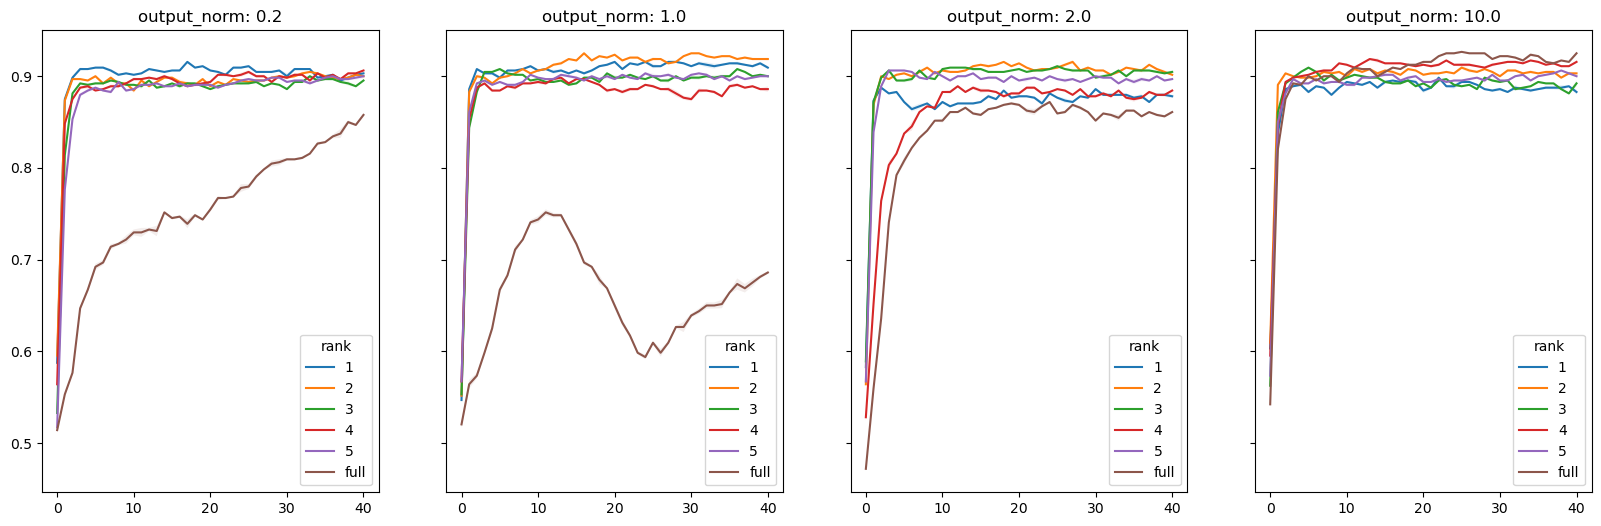

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_proj'

for prep_td in tqdm(prep_tds):
    rank = get_rec_rank(prep_td)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(prep_td), decimals = 2))
    cv_scores = get_classif_cv_scores_through_time(prep_td, classifier, signal, "cue_kappa", cv = StratifiedKFold(10, shuffle=True), progress_bar = False)
    plot_cv_scores_through_time(cv_scores, ax = ax[i], label = rank)
    
for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

Decode uncertainty level from the full rates

  0%|          | 0/24 [00:00<?, ?it/s]

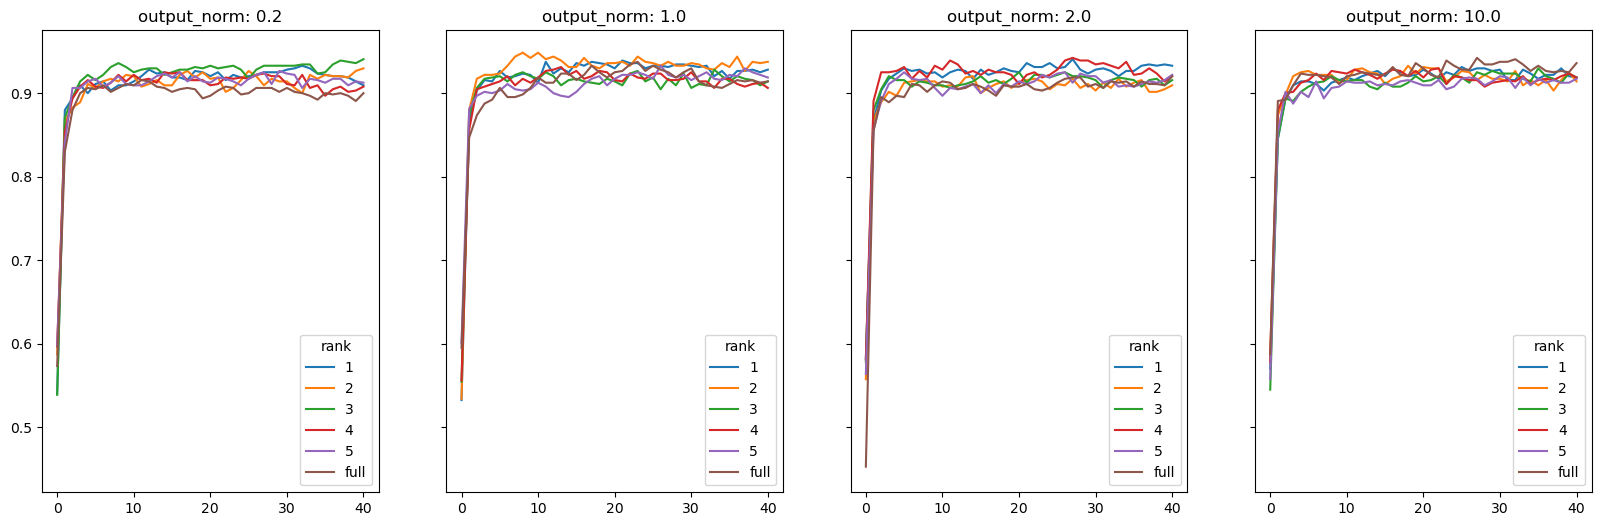

In [47]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_rates'

for prep_td in tqdm(prep_tds):
    rank = get_rec_rank(prep_td)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(prep_td), decimals = 2))
    cv_scores = get_classif_cv_scores_through_time(prep_td, classifier, signal, "cue_kappa", cv = StratifiedKFold(10, shuffle=True), progress_bar = False)
    plot_cv_scores_through_time(cv_scores, ax = ax[i], label = rank)
    
for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

Decode reach from the first few PCs

  0%|          | 0/24 [00:00<?, ?it/s]

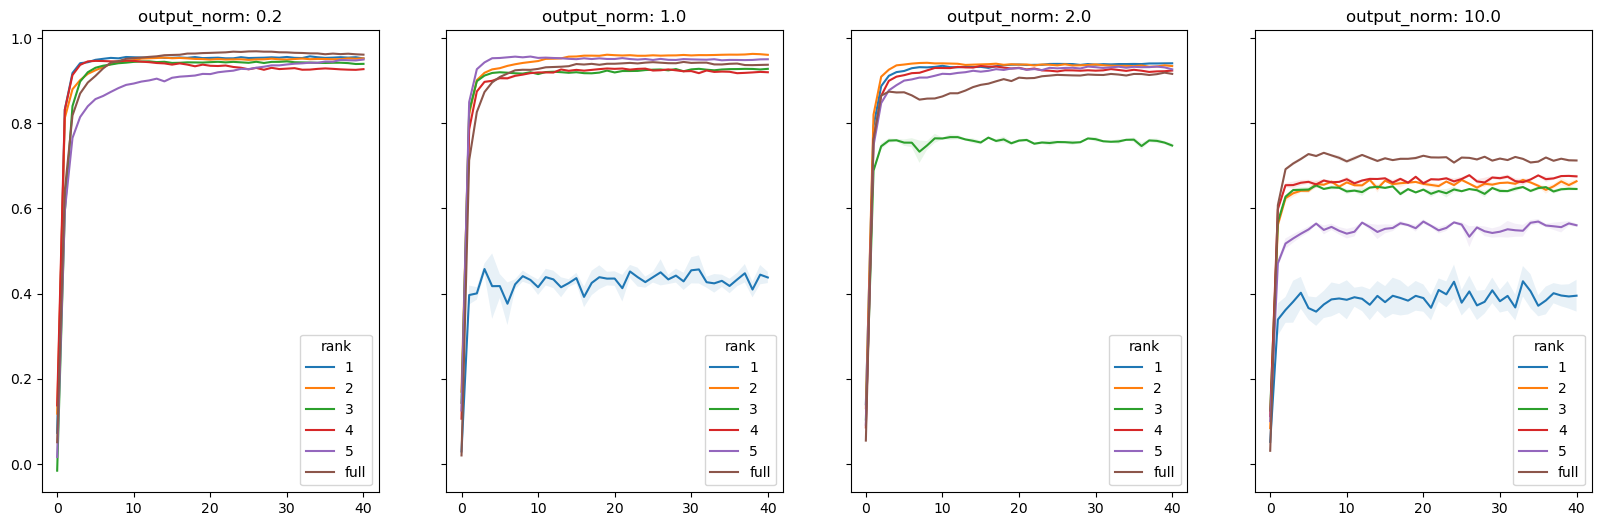

In [49]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_proj'

for prep_td in tqdm(prep_tds):
    rank = get_rec_rank(prep_td)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(prep_td), decimals = 2))
    cv_scores = get_regr_cv_scores_through_time(prep_td, regressor, signal, "endpoint_location", cv = KFold(10, shuffle=True), progress_bar = False)
    plot_cv_scores_through_time(cv_scores, ax = ax[i], label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

Decode reach from the full rates

  0%|          | 0/24 [00:00<?, ?it/s]

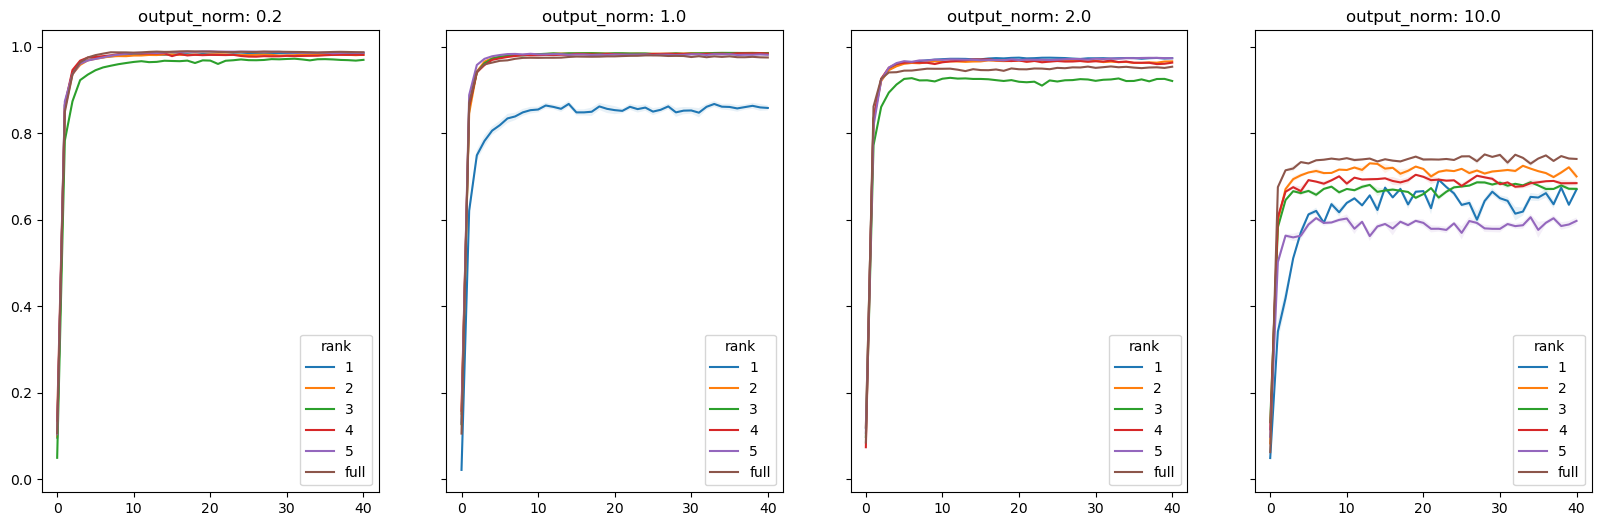

In [50]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_rates'

for prep_td in tqdm(prep_tds):
    rank = get_rec_rank(prep_td)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(prep_td), decimals = 2))
    cv_scores = get_regr_cv_scores_through_time(prep_td, regressor, signal, "endpoint_location", cv = KFold(10, shuffle=True), progress_bar = False)
    plot_cv_scores_through_time(cv_scores, ax = ax[i], label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

Decode reach throughout the trial from the projections

  0%|          | 0/24 [00:00<?, ?it/s]

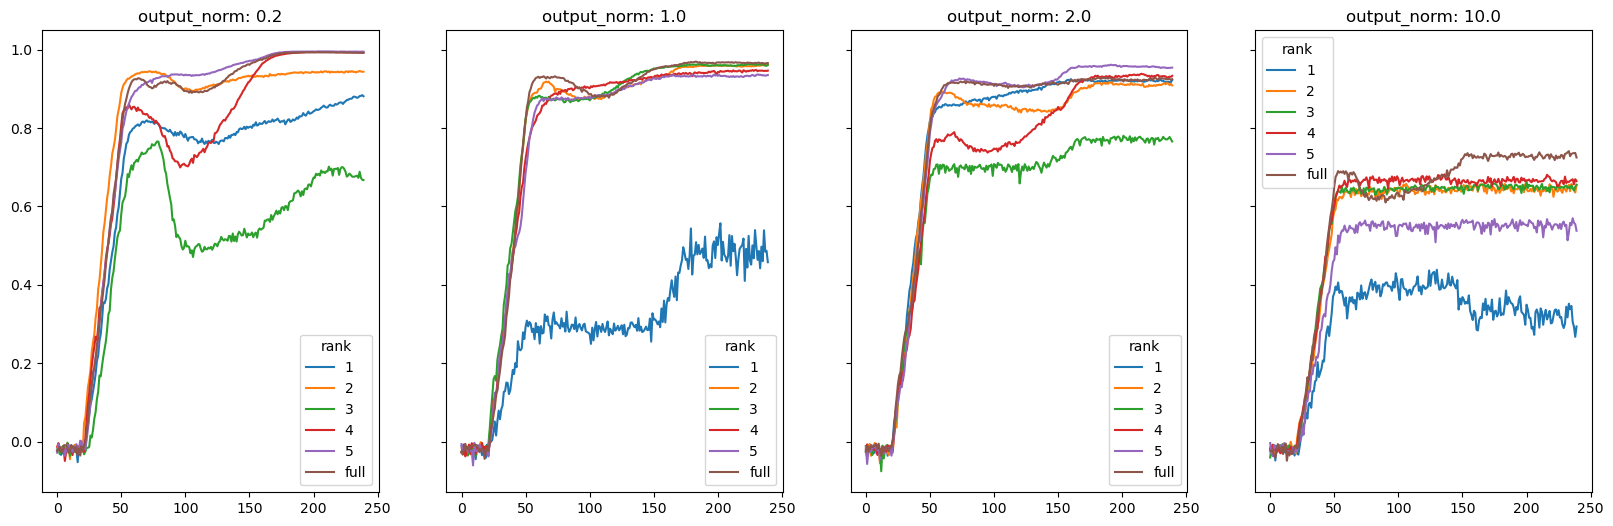

In [52]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_proj'
n_latents = 3

for df in tqdm(test_dataframes):
    df = dim_reduce(df, PCA(n_latents), 'PMd_rates', 'PMd_proj')
    
    rank = get_rec_rank(df)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(df), decimals = 2))
    cv_scores = get_regr_cv_scores_through_time(df, regressor, signal, "endpoint_location", cv = KFold(10, shuffle=True), progress_bar = False)
    #plot_cv_scores_through_time(cv_scores, ax = ax[i], label = get_rec_rank(df), plot_std = False)
    ax[i].plot(cv_scores.mean(axis = 1), label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

Decode reach throughout the trial from the full rates

  0%|          | 0/24 [00:00<?, ?it/s]

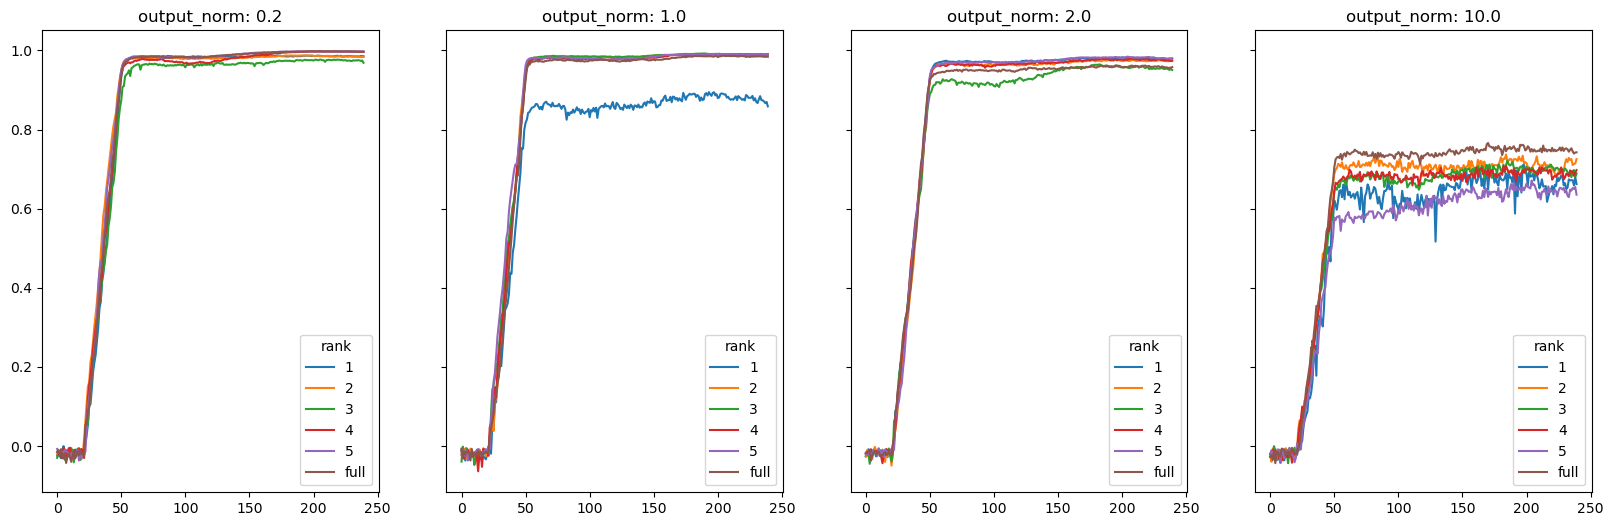

In [53]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_rates'

for df in tqdm(test_dataframes):
    rank = get_rec_rank(df)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(df), decimals = 2))
    cv_scores = get_regr_cv_scores_through_time(df, regressor, signal, "endpoint_location", cv = KFold(10, shuffle=True), progress_bar = False)
    #plot_cv_scores_through_time(cv_scores, ax = ax[i], label = get_rec_rank(df), plot_std = False)
    ax[i].plot(cv_scores.mean(axis = 1), label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

  0%|          | 0/24 [00:00<?, ?it/s]

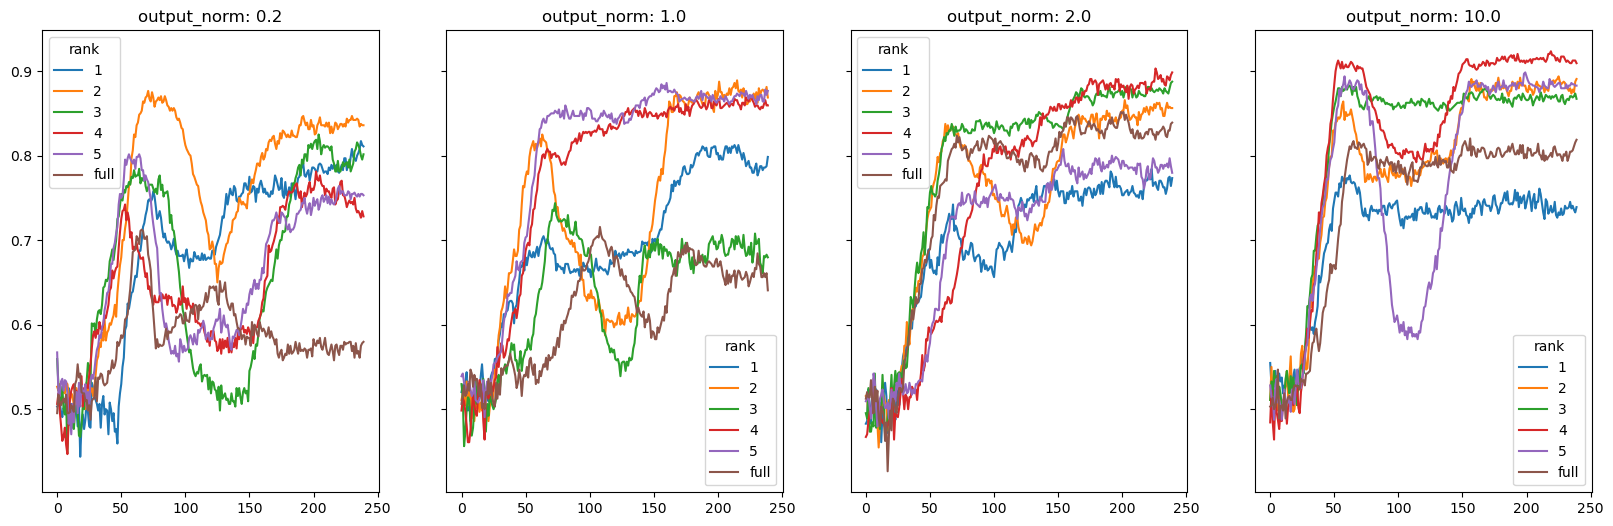

In [55]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_proj'
n_latents = 3

for df in tqdm(test_dataframes):
    df = dim_reduce(df, PCA(n_latents), 'PMd_rates', 'PMd_proj')
    
    rank = get_rec_rank(df)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(df), decimals = 2))
    cv_scores = get_classif_cv_scores_through_time(df, classifier, signal, "cue_kappa", cv = StratifiedKFold(10, shuffle=True), progress_bar = False)
    #plot_cv_scores_through_time(cv_scores, ax = ax[i], label = get_rec_rank(df), plot_std = False)
    ax[i].plot(cv_scores.mean(axis = 1), label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

  0%|          | 0/24 [00:00<?, ?it/s]

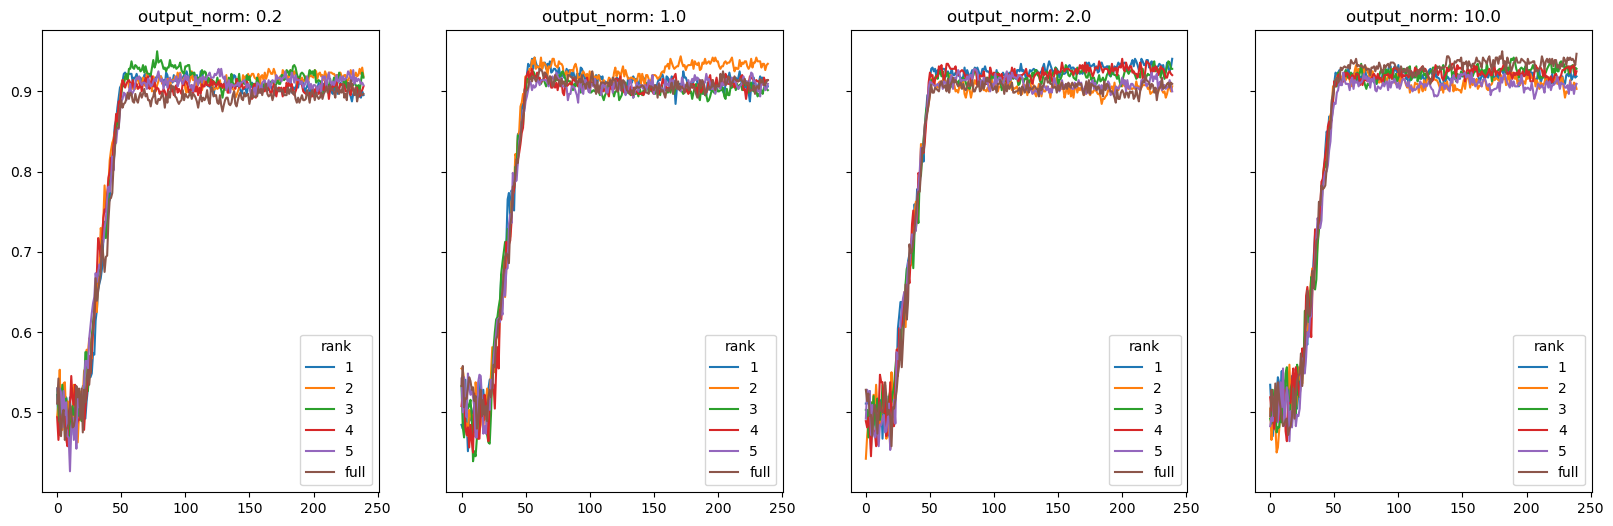

In [56]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (20, 6), ncols = len(output_norm_vals), sharey = True)

signal = 'PMd_rates'

for df in tqdm(test_dataframes):
    rank = get_rec_rank(df)
    if rank is None:
        rank = 'full'
        
    i = output_norm_vals.index(np.round(get_output_norm(df), decimals = 2))
    cv_scores = get_classif_cv_scores_through_time(df, classifier, signal, "cue_kappa", cv = StratifiedKFold(10, shuffle=True), progress_bar = False)
    #plot_cv_scores_through_time(cv_scores, ax = ax[i], label = get_rec_rank(df), plot_std = False)
    ax[i].plot(cv_scores.mean(axis = 1), label = rank)

for (output_norm, axi) in zip(output_norm_vals, ax):  
    axi.set_title(f"output_norm: {output_norm}")
    axi.legend(title = "rank")

# Trajectories 

In [57]:
test_dataframes = [dim_reduce(df, PCA(3), 'PMd_rates', 'PMd_proj') for df in test_dataframes]

In [58]:
%matplotlib widget
fig = go.Figure(layout = {'width' : 800, 'height' : 500})

interactive_trajectory_plot(test_dataframes)

interactive(children=(Dropdown(description='area', options=('PMd_proj', 'M1_proj', 'both_proj', 'model_output'…

In [77]:
#sampled_norms = [utils.glorot_gauss_tensor((2, n)).norm() for _ in range(1_000)]
#plt.hist(sampled_norms, bins = 50)

# Test with equally spaced cues 

In [85]:
# NOTE I just realized that this is probably not necessary if it's only used for testing
from pysubspaces.RNN.tasks import Task
from pysubspaces.RNN.reach_profile import speed_curve, extent_curve

class EqualSpacedUncertaintyTaskWithReachProfiles(Task):
    def __init__(self, dt, tau, T, N_batch, stim_noise=0.05, cue_kappa=5):
        super().__init__(11, 2, dt, tau, T, N_batch)
        self.stim_noise = stim_noise
        self.cue_kappa = cue_kappa
        self.gap = self.estimate_gap(self.cue_kappa)
        self.trial_num = 0
        self.target_dirs = np.linspace(0, np.pi, self.N_batch)

    def estimate_gap(self, cue_kappa):
        gaps = np.concatenate([np.diff(np.sort(np.random.vonmises(mu = 0, kappa = cue_kappa, size=5))) for i in range(10_000)])
        
        return np.median(gaps)
        
    def generate_trial_params(self, batch, trial):
        params = dict()
        
        target_dir = self.target_dirs[self.trial_num]
        params['target_dir'] = target_dir
        params['target_cos'] = np.cos(target_dir)
        params['target_sin'] = np.sin(target_dir)
        params['target_cossin'] = np.array([params['target_cos'], params['target_sin']])
        
        params['cue_kappa'] = self.cue_kappa
        params['gap'] = self.gap
        params['cue_slice_locations'] = [target_dir + j*self.gap for j in range(-2, 3)]
        
        params['idx_trial_start'] = 50
        params['idx_target_on']   = params['idx_trial_start'] + 100
        params['idx_go_cue']      = params['idx_target_on'] + 300
        params['idx_trial_end']   = params['idx_go_cue'] + 450
        
        params['stim_noise'] = self.stim_noise * np.random.randn(self.T, self.N_in)
        params['cue_input'] = np.array([np.cos(ang) for ang in params['cue_slice_locations']] + [np.sin(ang) for ang in params['cue_slice_locations']] + [0.])

        self.trial_num += 1

        return params
    
    def trial_function(self, time, params):
        target_cossin = params['target_cossin']
        
        # start with just noise
        input_signal = params['stim_noise'][time, :]
        
        # add the input after the target onset
        if time >= params['idx_target_on']:
            input_signal += params['cue_input']

        # go signal should be on after the go cue
        if time >= params['idx_go_cue']:
            input_signal += np.append(np.zeros(10), 1)
            
        # in the beginning the output is nothing, then it's the target's position on the circle
        if time < params['idx_go_cue']:
            output_signal = np.zeros(self.N_out)
        else:
            shifted_time = time - params['idx_go_cue']

            # position is the extent projected to the x and y axes
            extent_at_t = extent_curve(shifted_time)
            output_signal = target_cossin * extent_at_t
            
        # we always care about correct position
        if time > params['idx_trial_start']:
            mask_t = np.ones(self.N_out)
        else:
            mask_t = np.zeros(self.N_out)
            
        return input_signal, output_signal, mask_t

In [86]:
import pysubspaces.RNN.utils as utils

In [87]:
test_dfs = []
for res in tqdm(results):
    ck_test_dfs = []
    for ck in [5, 50]:
        params, training_task, rnn_state_dict, optimizer_state_dict, losses = res

        #test_task = tasks.EqualSpacedUncertaintyTask(dt, tau, L, 50, cue_kappa = ck)
        test_task = EqualSpacedUncertaintyTaskWithReachProfiles(dt, tau, L, 50, cue_kappa = ck)
        
        rnn = _instantiate_rnn(test_task, params)
        rnn.load_state_dict(rnn_state_dict)
        rnn.rec_rank = params['rec_rank']
        rnn.noisy = False
        #optimizer.load_state_dict(optimizer_state_dict)
        assert np.isclose(rnn.W_out.norm(), params['output_norm'])
        
        ck_test_df = run_test_batches(1, rnn, test_task)
        
        ck_test_df['out_norm'] = params['output_norm']
        ck_test_df['rec_rank'] = params['rec_rank']
        
        ck_test_dfs.append(ck_test_df)
        
    test_dfs.append(pd.concat(ck_test_dfs))

  0%|          | 0/24 [00:00<?, ?it/s]

In [88]:
#test_df = test_df.query(f"0.5 < endpoint_location < {np.pi}-0.5")

## Behavior

/home/bb2020/research_code/pysubspaces/pysubspaces/RNN/plotting.py:54: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



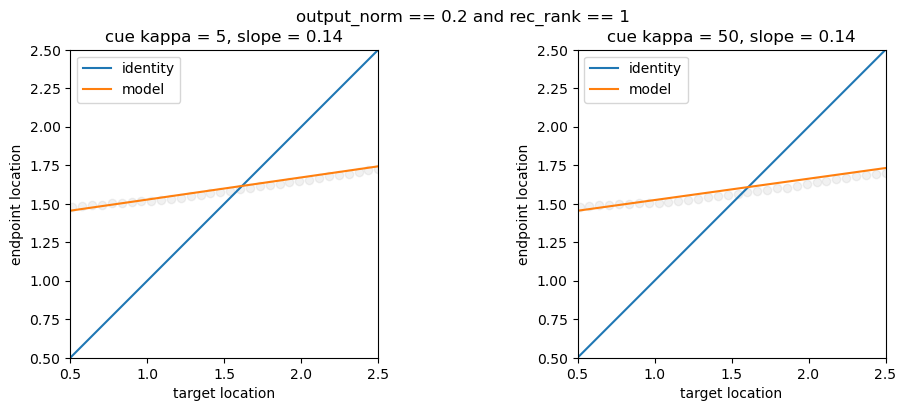

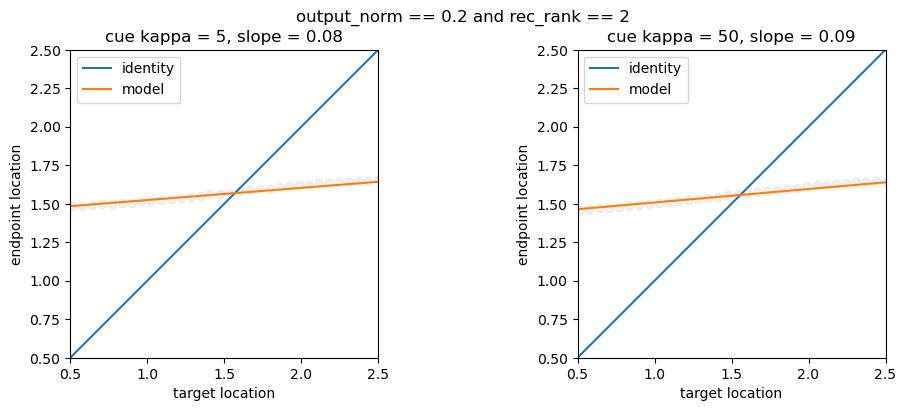

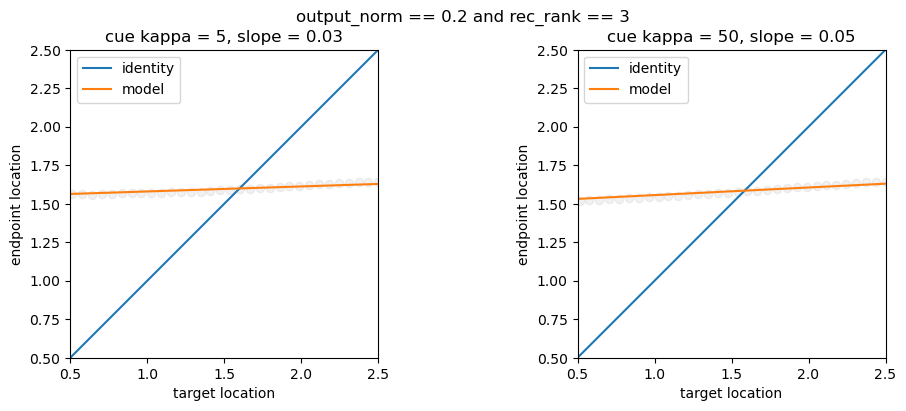

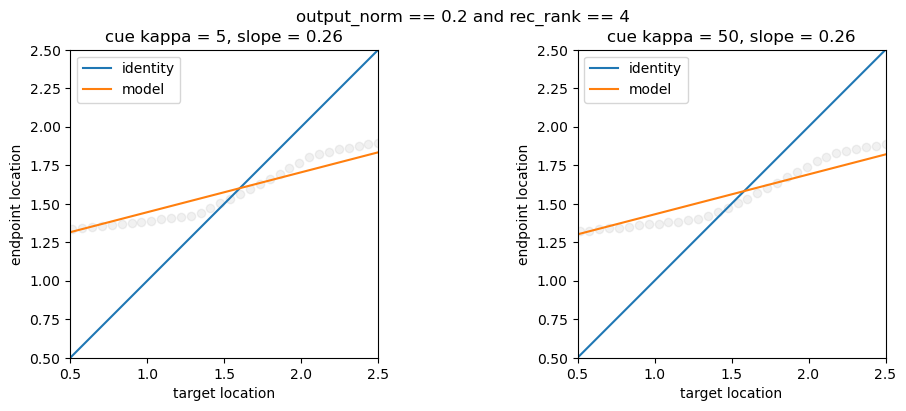

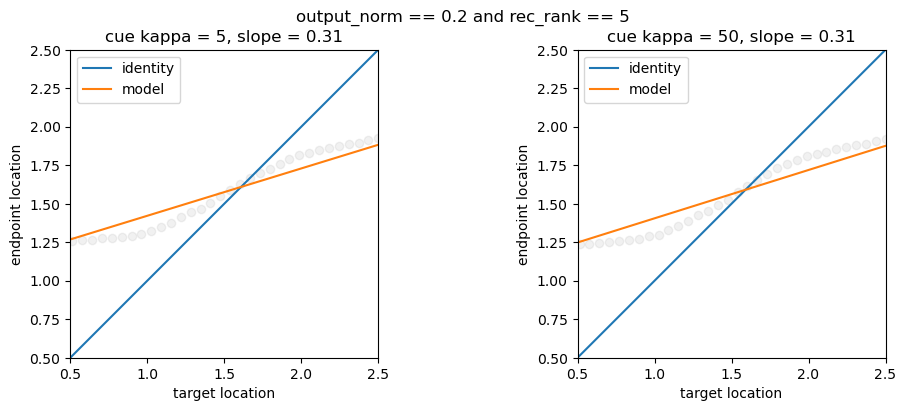

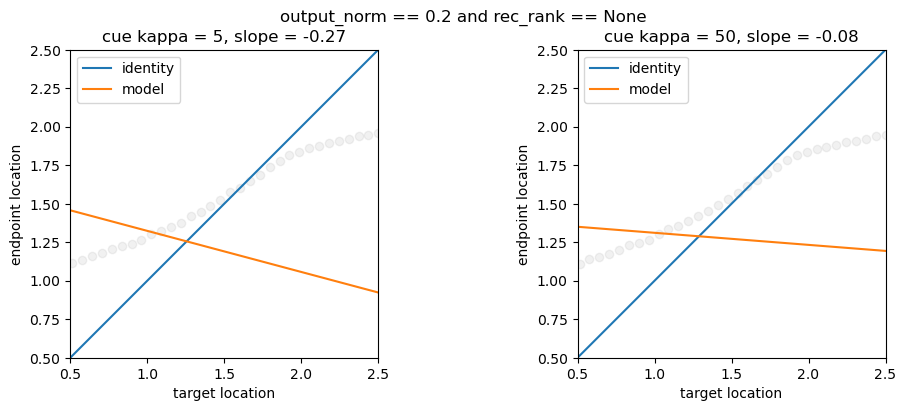

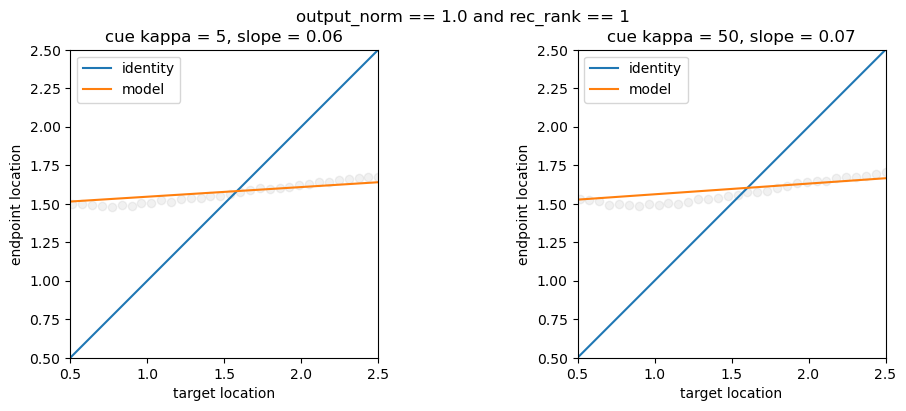

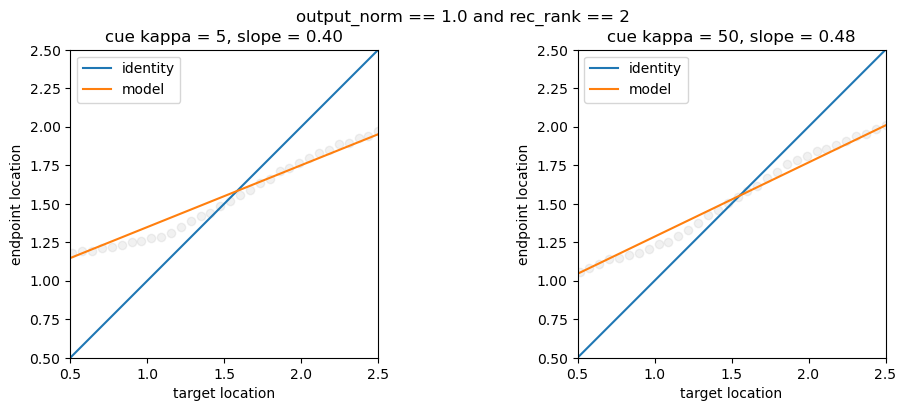

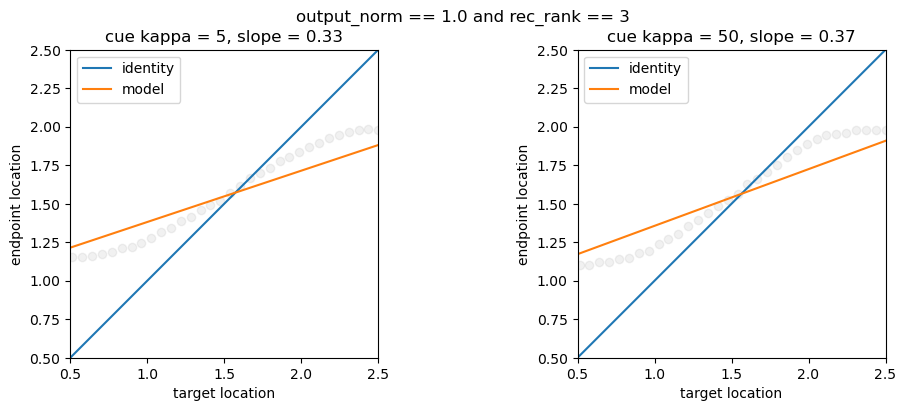

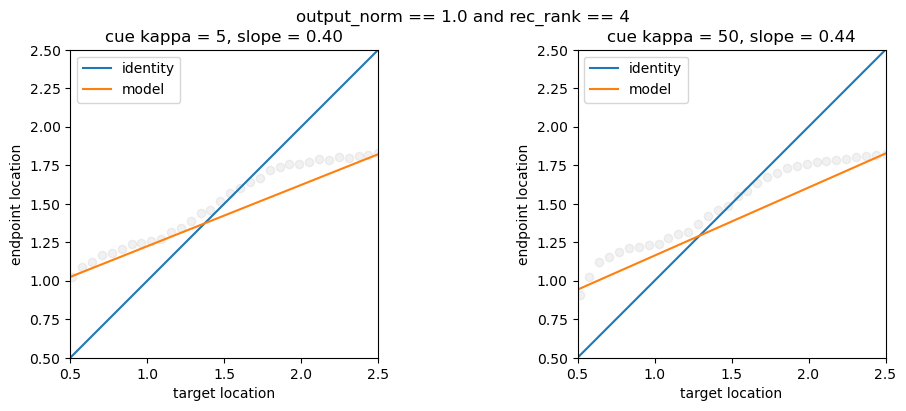

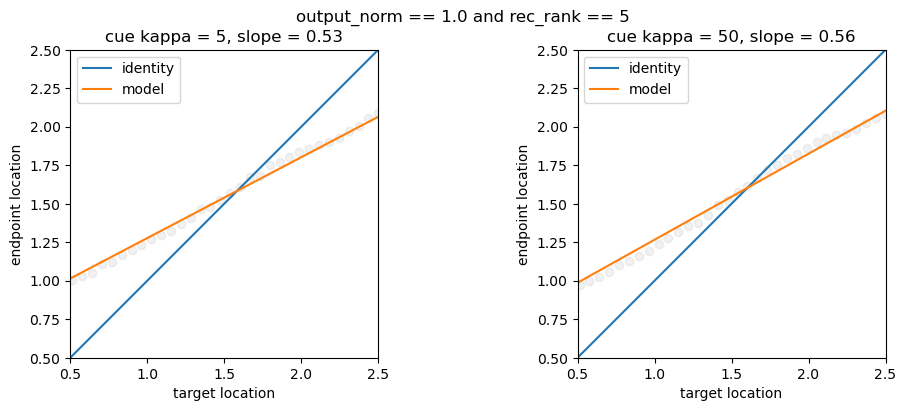

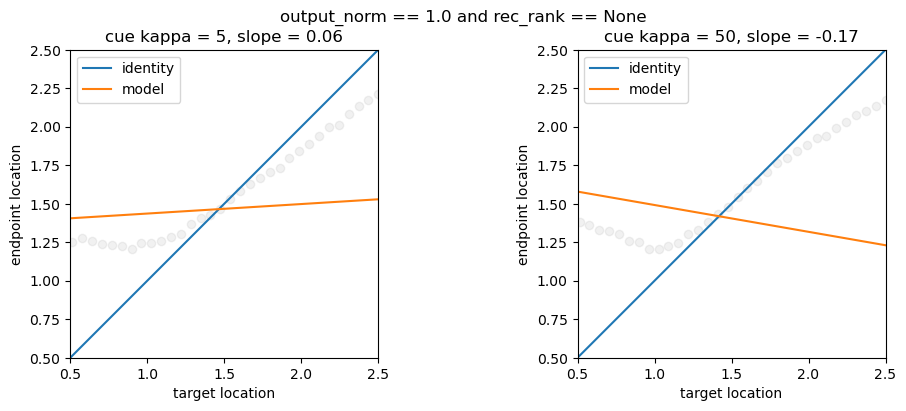

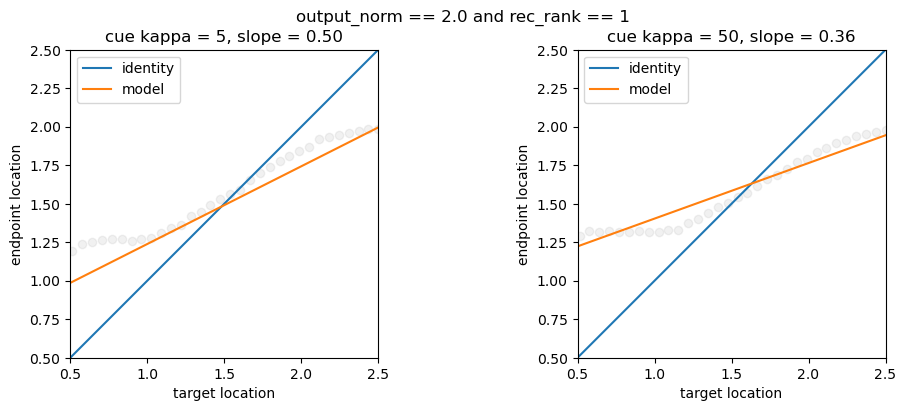

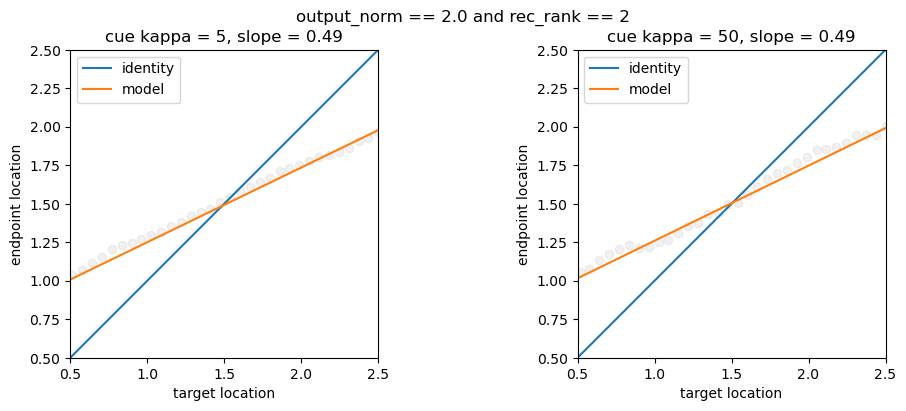

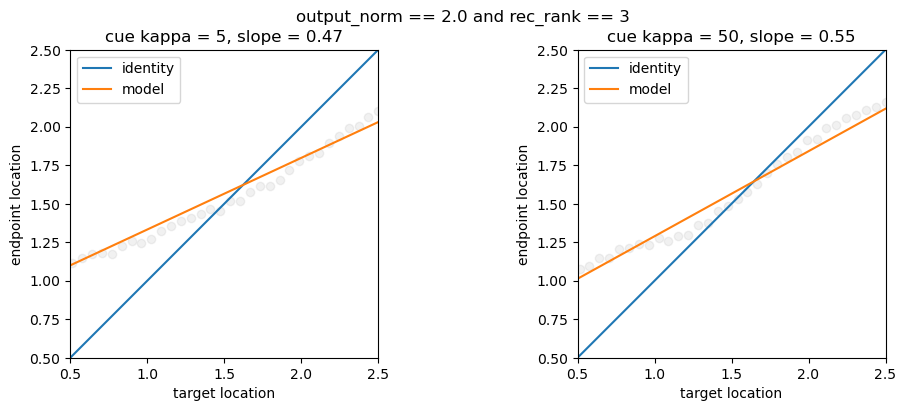

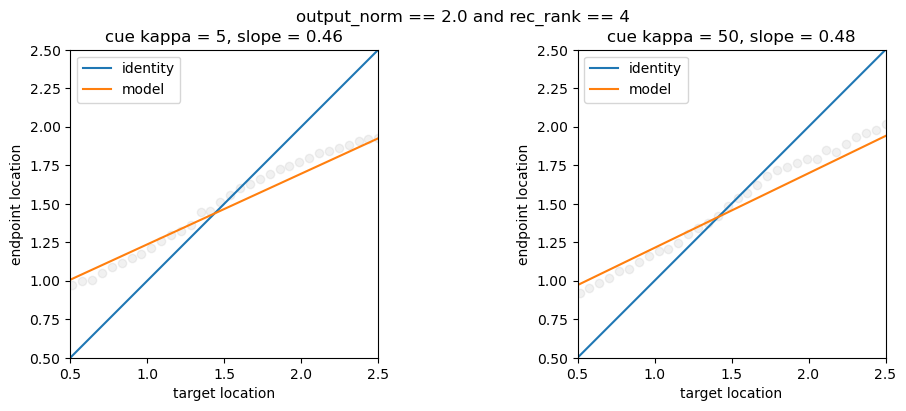

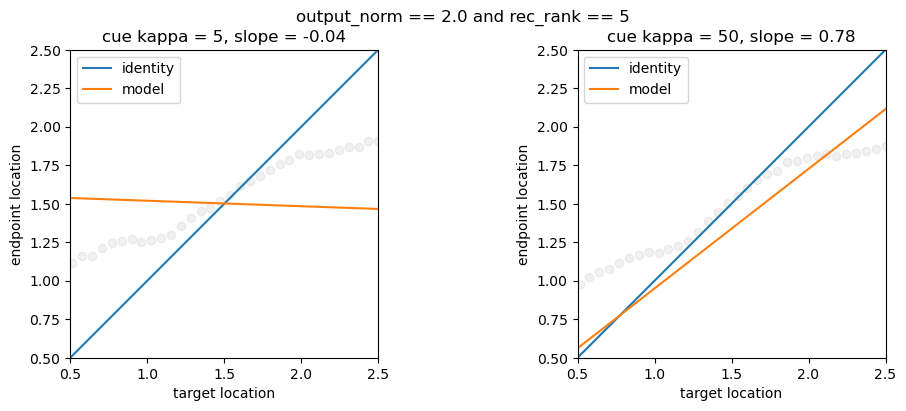

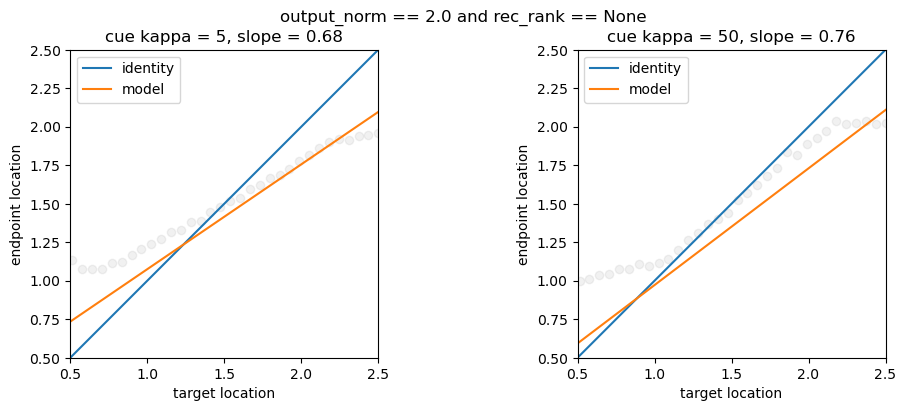

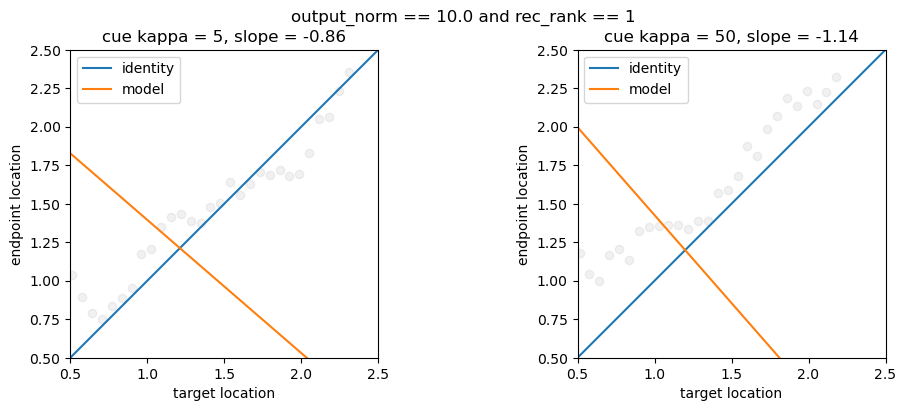

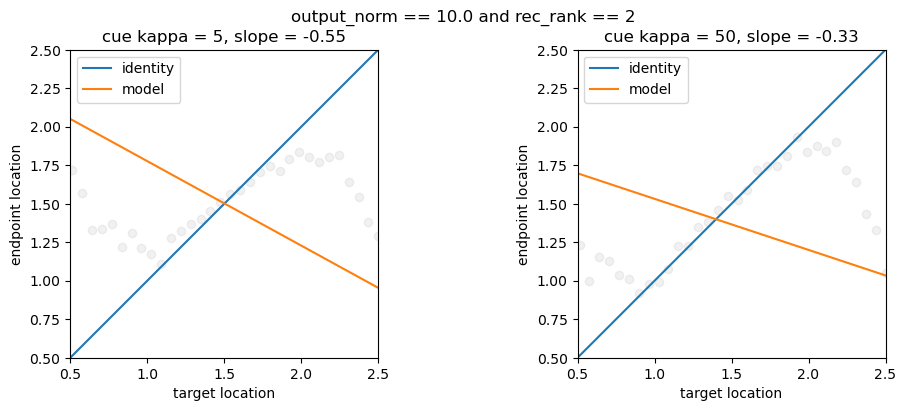

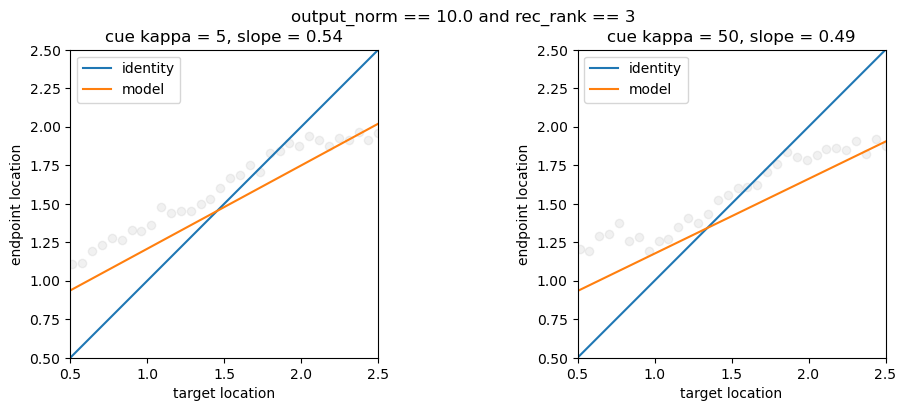

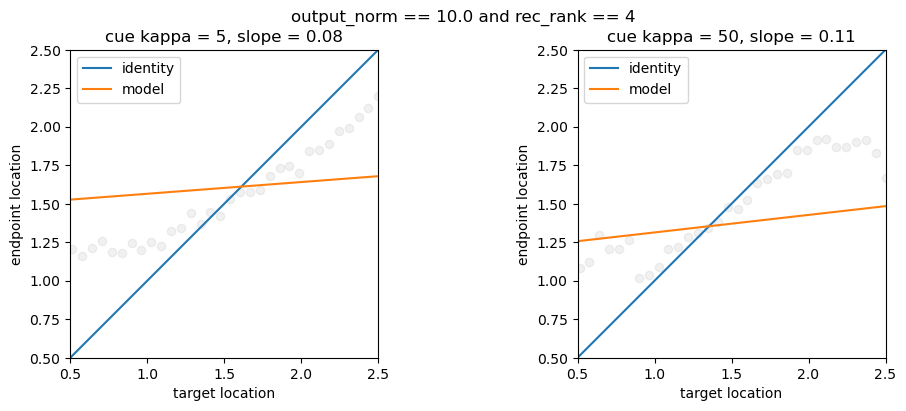

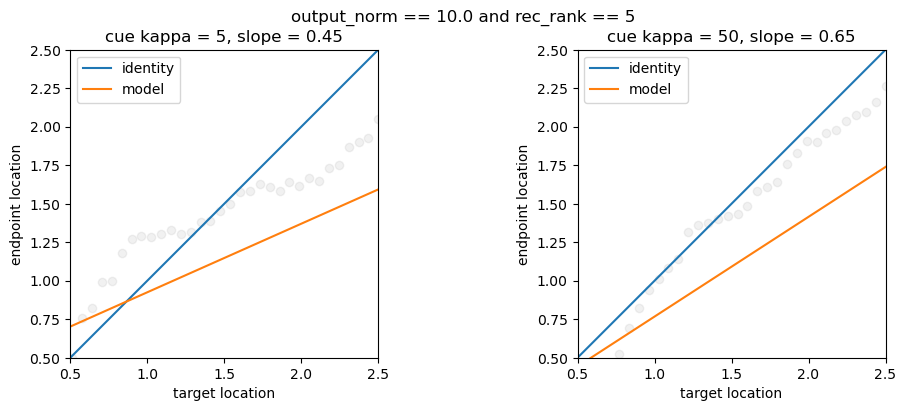

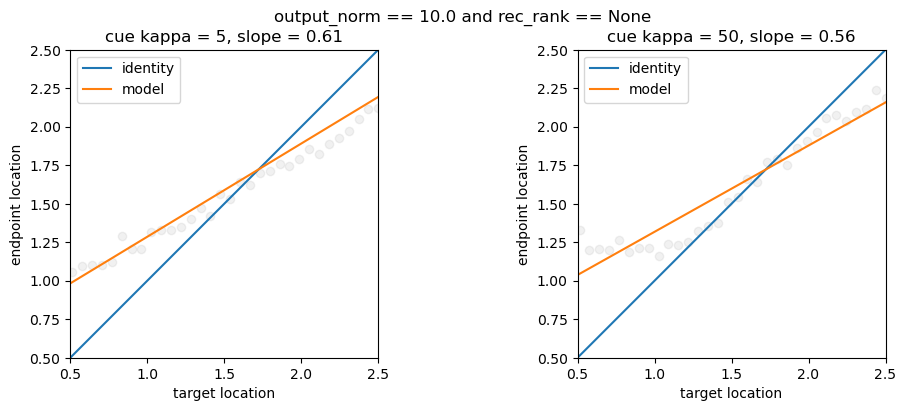

In [90]:
%matplotlib inline
for test_df in test_dfs:
    fig, ax = make_bias_plot_per_cue_kappa(test_df);

    fig.suptitle(f"output_norm == {get_output_norm(test_df)} and rec_rank == {get_rec_rank(test_df)}")

## Trajectories through the whole trial 

In [91]:
test_dfs = [restrict_to_interval(test_df, 'idx_target_on', 'idx_trial_end') for test_df in test_dfs]
test_dfs = [dim_reduce(test_df, PCA(n_latents), 'PMd_rates', 'PMd_proj') for test_df in test_dfs]

In [92]:
%matplotlib widget
fig = go.Figure(layout = {'width' : 800, 'height' : 500})

interactive_trajectory_plot(test_dfs)

interactive(children=(Dropdown(description='area', options=('PMd_proj', 'M1_proj', 'both_proj', 'model_output'…